In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

from time import time

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
import torch.optim as optim

In [3]:
torch.__version__

'0.4.0'

In [4]:
USE_CUDA = torch.cuda.is_available()
USE_CUDA

True

In [5]:
device = torch.device('cuda:3' if USE_CUDA else 'cpu')

In [6]:
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader

In [7]:
batch_size = 100

In [8]:
kwargs = {'num_workers': 1, 'pin_memory': True} if USE_CUDA else {}

dataset = CIFAR10

train_loader = torch.utils.data.DataLoader(
    dataset(
        './data', train=True, download=True, transform=transforms.ToTensor()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

test_loader = torch.utils.data.DataLoader(
    dataset(
        './data', train=False, transform=transforms.ToTensor()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

Files already downloaded and verified


In [9]:
print(train_loader.dataset.train_data.shape)
print(test_loader.dataset.test_data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [10]:
from sklearn.model_selection import train_test_split

train_dataset_labelled, train_dataset_unlabelled, train_labels_labelled, train_labels_unlabelled = train_test_split(
    train_loader.dataset.train_data, np.array(train_loader.dataset.train_labels), train_size=4000
)
train_dataset_labelled.shape, train_dataset_unlabelled.shape, train_labels_labelled.shape, train_labels_unlabelled.shape

/home/golikov/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


((4000, 32, 32, 3), (46000, 32, 32, 3), (4000,), (46000,))

In [11]:
np.sum(np.array(train_loader.dataset.train_labels) == 0) / np.array(train_loader.dataset.train_labels).shape[0]

0.10000000000000001

In [12]:
np.max(train_dataset_labelled)

255

In [13]:
train_loader_labelled = DataLoader(
    TensorDataset(
        torch.from_numpy(np.transpose(train_dataset_labelled, (0,3,1,2))).float() / 255, 
        torch.Tensor(train_labels_labelled).long()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)
train_loader_unlabelled = DataLoader(
    TensorDataset(
        torch.from_numpy(np.transpose(train_dataset_unlabelled, (0,3,1,2))).float() / 255, 
        torch.Tensor(train_labels_unlabelled).long()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

In [14]:
input_shape = train_loader.dataset.train_data.shape[1:]
input_shape = input_shape[-1:] + input_shape[:-1]
output_size = 10

In [15]:
name_prefix = 'double_backprop_results/'

**Double backprop**

In [16]:
def constrain_loss_function(model, batch_gen, use_all_classes=False):
    X_gen, _ = next(batch_gen)
    X_gen = X_gen.to(device).requires_grad_()
    model_output = model(X_gen) # [batch_size x num_classes]
    
    if use_all_classes:
        grad_output_wrt_input_for_each_class = []
        for output in torch.unbind(torch.sum(model_output, dim=0)):
            grad_output_wrt_input_for_each_class.append(
                autograd.grad([output], [X_gen], create_graph=True)[0]
            ) # [batch_size x latent_dim]
        grad_output_wrt_input = torch.stack(
            grad_output_wrt_input_for_each_class
        ) # [num_classes x batch_size x latent_dim]
        return torch.sum(grad_output_wrt_input ** 2) / batch_size
    else:
        y = np.random.choice(output_size)
        output = torch.sum(model_output, dim=0)[y]
        grad_output_wrt_input = autograd.grad(
            [output], [X_gen], create_graph=True
        )[0]
        return output_size * torch.sum(grad_output_wrt_input ** 2) / batch_size

**Training**

In [17]:
class ModelConvolutional(nn.Module):
    def __init__(
        self, input_shape, output_size 
    ):
        super(type(self), self).__init__()
        assert input_shape[1] == input_shape[2]
        self.layers = nn.ModuleList([
            nn.Dropout(p=0.2),
            nn.Conv2d(input_shape[0], 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(96, 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(96, 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(96),
            
            nn.Dropout(p=0.5),
            nn.Conv2d(96, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(192),
            
            nn.Dropout(p=0.5),
            nn.Conv2d(192, 192, 3),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.AvgPool2d(6)
        ])
        self.output_layer = nn.utils.weight_norm(nn.Linear(192, 10))
        
    def forward(self, X):
        for layer in self.layers:
            X = layer(X)
        X = X.view(X.shape[0], -1)
        return F.log_softmax(self.output_layer(X), dim=1)

In [18]:
train_losses = {}
train_accs = {}

test_losses = {}
test_accs = {}

In [20]:
num_epochs = 200
num_runs = 5
save_every = 10

modes = ['eta=' + str(eta) for eta in [0, 1e-5, 1e-4, 1e-3, 1e-2]]

loss_function = nn.NLLLoss()

for mode in modes:
    mode_name = mode + '__labelled=4000__epochs=' + str(num_epochs)
    eta = float(mode.split('=')[1])

    print('Mode:', mode)
    print(mode_name)
    print('eta =', eta)
    print()
    
    train_losses[mode] = []
    train_accs[mode] = []
    
    test_losses[mode] = []
    test_accs[mode] = []

    torch.manual_seed(123)
    np.random.seed(123)
    for run in range(num_runs):
        print('run', run+1)
        
        train_losses[mode].append([])
        train_accs[mode].append([])
    
        test_losses[mode].append([])
        test_accs[mode].append([])

        model = ModelConvolutional(input_shape, output_size).to(device)
        optimizer = optim.Adam(model.parameters(), lr=3e-4, betas=(0.5, 0.999))
        #scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda k: ((num_epochs-k)/200 if k >= num_epochs-200 else 1))
    
        for epoch in range(num_epochs):
            start_time = time()
    
            #scheduler.step()
    
            cum_loss_data = 0
            cum_loss_constrain = 0
            cum_loss_full = 0
            cum_acc = 0
            batch_count = 0

            model.train()
            train_iter_unlabelled = iter(train_loader_unlabelled)
            for X, y in train_loader_labelled:
                X, y = X.to(device), y.to(device)
                prediction = model(X)
                loss_data = loss_function(prediction, y)
                cum_loss_data += loss_data.item()
        
                loss_constrain = constrain_loss_function(
                    model, use_all_classes=False, batch_gen=train_iter_unlabelled
                )
                cum_loss_constrain += loss_constrain.item()
        
                loss_full = loss_data + eta * loss_constrain
                cum_loss_full += loss_full.item()
            
                acc = torch.mean((torch.max(prediction, dim=-1)[1] == y).float())
                cum_acc += acc.item()
        
                optimizer.zero_grad()
                loss_full.backward()
                optimizer.step()
                batch_count += 1
            
            mean_train_loss_data = cum_loss_data / batch_count
            mean_train_loss_constrain = cum_loss_constrain / batch_count
            mean_train_loss_full = cum_loss_full / batch_count
            mean_train_acc = cum_acc / batch_count

            train_losses[mode][-1].append(mean_train_loss_data)
            train_accs[mode][-1].append(mean_train_acc)
        
            cum_loss_data = 0
            cum_loss_constrain = 0
            cum_acc = 0
            batch_count = 0

            model.eval()
            with torch.no_grad():
                for X, y in test_loader:
                    X, y = X.to(device), y.to(device)
                    prediction = model(X)
                    loss_data = loss_function(prediction, y)
                    cum_loss_data += loss_data.item()
        
                    acc = torch.mean((torch.max(prediction, dim=-1)[1] == y).float())
                    cum_acc += acc.item()
        
                    batch_count += 1
            
            mean_test_loss_data = cum_loss_data / batch_count
            mean_test_loss_constrain = cum_loss_constrain / batch_count
            mean_test_acc = cum_acc / batch_count

            test_losses[mode][-1].append(mean_test_loss_data)
            test_accs[mode][-1].append(mean_test_acc)
        
            print('Epoch {} of {} took {:.2f}s;'.format(epoch+1, num_epochs, time() - start_time))
            print('train loss:')
            print(
                'data term: {:.2f}, constrain term: {:.2f}, full: {:.2f}'.format(
                    mean_train_loss_data, mean_train_loss_constrain, mean_train_loss_full
                )
            )
            print('train acc: {:.2f}'.format(mean_train_acc*100))
            print('test loss:')
            print(
                'data term: {:.2f}, constrain term: {:.2f}'.format(
                    mean_test_loss_data, mean_test_loss_constrain
                )
            )
            print('test acc: {:.2f}'.format(mean_test_acc*100))
            print()
        
            if (epoch+1) % save_every == 0:
                with open(name_prefix + mode_name + '/train_losses.pkl', 'wb') as f:
                    pickle.dump(np.array(train_losses[mode]), f)
                with open(name_prefix + mode_name + '/test_losses.pkl', 'wb') as f:
                    pickle.dump(np.array(test_losses[mode]), f)
                with open(name_prefix + mode_name + '/train_accs.pkl', 'wb') as f:
                    pickle.dump(np.array(train_accs[mode]), f)
                with open(name_prefix + mode_name + '/test_accs.pkl', 'wb') as f:
                    pickle.dump(np.array(test_accs[mode]), f)

                torch.save(model.state_dict(), name_prefix + mode_name + '/model.pt')

    train_losses[mode] = np.array(train_losses[mode])
    test_losses[mode] = np.array(test_losses[mode])
    train_accs[mode] = np.array(train_accs[mode])
    test_accs[mode] = np.array(test_accs[mode])
    

Mode: eta=0
eta=0__labelled=4000__epochs=200
eta = 0.0

run 1
Epoch 1 of 200 took 11.56s;
train loss:
data term: 2.03, constrain term: 0.09, full: 2.03
train acc: 26.30
test loss:
data term: 2.20, constrain term: 0.00
test acc: 20.27

Epoch 2 of 200 took 11.55s;
train loss:
data term: 1.83, constrain term: 0.25, full: 1.83
train acc: 33.73
test loss:
data term: 2.09, constrain term: 0.00
test acc: 23.83

Epoch 3 of 200 took 11.52s;
train loss:
data term: 1.72, constrain term: 0.59, full: 1.72
train acc: 37.35
test loss:
data term: 1.95, constrain term: 0.00
test acc: 26.72

Epoch 4 of 200 took 11.52s;
train loss:
data term: 1.66, constrain term: 1.00, full: 1.66
train acc: 40.67
test loss:
data term: 1.98, constrain term: 0.00
test acc: 27.70

Epoch 5 of 200 took 11.51s;
train loss:
data term: 1.60, constrain term: 1.44, full: 1.60
train acc: 42.37
test loss:
data term: 1.87, constrain term: 0.00
test acc: 31.66

Epoch 6 of 200 took 11.55s;
train loss:
data term: 1.57, constrain term: 

Epoch 48 of 200 took 11.53s;
train loss:
data term: 0.50, constrain term: 148.41, full: 0.50
train acc: 84.95
test loss:
data term: 1.29, constrain term: 0.00
test acc: 58.27

Epoch 49 of 200 took 11.55s;
train loss:
data term: 0.49, constrain term: 161.47, full: 0.49
train acc: 85.25
test loss:
data term: 1.55, constrain term: 0.00
test acc: 51.73

Epoch 50 of 200 took 11.55s;
train loss:
data term: 0.48, constrain term: 169.46, full: 0.48
train acc: 85.45
test loss:
data term: 1.43, constrain term: 0.00
test acc: 54.65

Epoch 51 of 200 took 11.49s;
train loss:
data term: 0.45, constrain term: 179.73, full: 0.45
train acc: 86.03
test loss:
data term: 1.32, constrain term: 0.00
test acc: 56.75

Epoch 52 of 200 took 11.76s;
train loss:
data term: 0.44, constrain term: 192.06, full: 0.44
train acc: 86.33
test loss:
data term: 1.27, constrain term: 0.00
test acc: 59.78

Epoch 53 of 200 took 11.53s;
train loss:
data term: 0.42, constrain term: 200.31, full: 0.42
train acc: 87.68
test loss:

Epoch 95 of 200 took 11.54s;
train loss:
data term: 0.11, constrain term: 713.48, full: 0.11
train acc: 97.35
test loss:
data term: 1.32, constrain term: 0.00
test acc: 64.25

Epoch 96 of 200 took 11.55s;
train loss:
data term: 0.11, constrain term: 726.64, full: 0.11
train acc: 97.45
test loss:
data term: 1.88, constrain term: 0.00
test acc: 55.22

Epoch 97 of 200 took 11.59s;
train loss:
data term: 0.11, constrain term: 693.19, full: 0.11
train acc: 97.28
test loss:
data term: 1.47, constrain term: 0.00
test acc: 61.02

Epoch 98 of 200 took 11.54s;
train loss:
data term: 0.11, constrain term: 716.24, full: 0.11
train acc: 97.15
test loss:
data term: 1.27, constrain term: 0.00
test acc: 65.03

Epoch 99 of 200 took 11.55s;
train loss:
data term: 0.11, constrain term: 726.08, full: 0.11
train acc: 97.28
test loss:
data term: 1.32, constrain term: 0.00
test acc: 64.28

Epoch 100 of 200 took 11.56s;
train loss:
data term: 0.11, constrain term: 731.14, full: 0.11
train acc: 97.55
test loss

Epoch 142 of 200 took 11.53s;
train loss:
data term: 0.07, constrain term: 1128.96, full: 0.07
train acc: 98.23
test loss:
data term: 1.36, constrain term: 0.00
test acc: 65.85

Epoch 143 of 200 took 11.53s;
train loss:
data term: 0.05, constrain term: 1165.48, full: 0.05
train acc: 98.63
test loss:
data term: 1.42, constrain term: 0.00
test acc: 64.91

Epoch 144 of 200 took 11.56s;
train loss:
data term: 0.07, constrain term: 1154.64, full: 0.07
train acc: 98.20
test loss:
data term: 1.47, constrain term: 0.00
test acc: 64.40

Epoch 145 of 200 took 11.54s;
train loss:
data term: 0.05, constrain term: 1172.45, full: 0.05
train acc: 98.63
test loss:
data term: 1.38, constrain term: 0.00
test acc: 65.90

Epoch 146 of 200 took 11.53s;
train loss:
data term: 0.05, constrain term: 1164.57, full: 0.05
train acc: 99.08
test loss:
data term: 1.38, constrain term: 0.00
test acc: 65.80

Epoch 147 of 200 took 11.53s;
train loss:
data term: 0.05, constrain term: 1182.85, full: 0.05
train acc: 98.6

Epoch 189 of 200 took 11.52s;
train loss:
data term: 0.05, constrain term: 1565.21, full: 0.05
train acc: 98.70
test loss:
data term: 1.70, constrain term: 0.00
test acc: 62.61

Epoch 190 of 200 took 11.53s;
train loss:
data term: 0.03, constrain term: 1628.65, full: 0.03
train acc: 99.50
test loss:
data term: 1.51, constrain term: 0.00
test acc: 65.53

Epoch 191 of 200 took 11.74s;
train loss:
data term: 0.04, constrain term: 1607.69, full: 0.04
train acc: 98.85
test loss:
data term: 1.84, constrain term: 0.00
test acc: 61.65

Epoch 192 of 200 took 11.54s;
train loss:
data term: 0.05, constrain term: 1598.17, full: 0.05
train acc: 98.63
test loss:
data term: 1.55, constrain term: 0.00
test acc: 65.70

Epoch 193 of 200 took 11.55s;
train loss:
data term: 0.03, constrain term: 1621.03, full: 0.03
train acc: 99.45
test loss:
data term: 1.61, constrain term: 0.00
test acc: 65.31

Epoch 194 of 200 took 11.56s;
train loss:
data term: 0.03, constrain term: 1664.28, full: 0.03
train acc: 99.2

Epoch 36 of 200 took 11.53s;
train loss:
data term: 0.72, constrain term: 80.77, full: 0.72
train acc: 76.32
test loss:
data term: 1.25, constrain term: 0.00
test acc: 56.21

Epoch 37 of 200 took 11.55s;
train loss:
data term: 0.70, constrain term: 85.94, full: 0.70
train acc: 77.28
test loss:
data term: 1.16, constrain term: 0.00
test acc: 58.94

Epoch 38 of 200 took 11.55s;
train loss:
data term: 0.69, constrain term: 92.06, full: 0.69
train acc: 77.98
test loss:
data term: 1.25, constrain term: 0.00
test acc: 56.68

Epoch 39 of 200 took 11.55s;
train loss:
data term: 0.67, constrain term: 99.56, full: 0.67
train acc: 77.78
test loss:
data term: 1.16, constrain term: 0.00
test acc: 59.65

Epoch 40 of 200 took 11.79s;
train loss:
data term: 0.64, constrain term: 107.23, full: 0.64
train acc: 79.70
test loss:
data term: 1.12, constrain term: 0.00
test acc: 60.77

Epoch 41 of 200 took 11.52s;
train loss:
data term: 0.62, constrain term: 110.18, full: 0.62
train acc: 80.02
test loss:
dat

Epoch 83 of 200 took 11.54s;
train loss:
data term: 0.17, constrain term: 556.09, full: 0.17
train acc: 94.98
test loss:
data term: 1.42, constrain term: 0.00
test acc: 61.00

Epoch 84 of 200 took 11.53s;
train loss:
data term: 0.15, constrain term: 570.47, full: 0.15
train acc: 96.18
test loss:
data term: 1.21, constrain term: 0.00
test acc: 64.55

Epoch 85 of 200 took 11.55s;
train loss:
data term: 0.14, constrain term: 564.91, full: 0.14
train acc: 96.55
test loss:
data term: 1.12, constrain term: 0.00
test acc: 65.58

Epoch 86 of 200 took 11.53s;
train loss:
data term: 0.14, constrain term: 596.16, full: 0.14
train acc: 96.45
test loss:
data term: 1.32, constrain term: 0.00
test acc: 62.54

Epoch 87 of 200 took 11.56s;
train loss:
data term: 0.13, constrain term: 614.52, full: 0.13
train acc: 96.78
test loss:
data term: 1.16, constrain term: 0.00
test acc: 65.16

Epoch 88 of 200 took 11.56s;
train loss:
data term: 0.14, constrain term: 616.70, full: 0.14
train acc: 96.30
test loss:

Epoch 130 of 200 took 11.55s;
train loss:
data term: 0.05, constrain term: 1054.05, full: 0.05
train acc: 98.98
test loss:
data term: 1.35, constrain term: 0.00
test acc: 65.81

Epoch 131 of 200 took 11.77s;
train loss:
data term: 0.06, constrain term: 1075.68, full: 0.06
train acc: 98.38
test loss:
data term: 1.32, constrain term: 0.00
test acc: 65.74

Epoch 132 of 200 took 11.54s;
train loss:
data term: 0.05, constrain term: 1051.83, full: 0.05
train acc: 98.75
test loss:
data term: 1.33, constrain term: 0.00
test acc: 65.70

Epoch 133 of 200 took 11.53s;
train loss:
data term: 0.07, constrain term: 1080.49, full: 0.07
train acc: 98.23
test loss:
data term: 1.28, constrain term: 0.00
test acc: 66.83

Epoch 134 of 200 took 11.52s;
train loss:
data term: 0.06, constrain term: 1104.38, full: 0.06
train acc: 98.75
test loss:
data term: 1.43, constrain term: 0.00
test acc: 64.71

Epoch 135 of 200 took 11.54s;
train loss:
data term: 0.08, constrain term: 1100.50, full: 0.08
train acc: 98.0

Epoch 177 of 200 took 11.56s;
train loss:
data term: 0.04, constrain term: 1476.17, full: 0.04
train acc: 99.10
test loss:
data term: 1.67, constrain term: 0.00
test acc: 63.11

Epoch 178 of 200 took 11.53s;
train loss:
data term: 0.04, constrain term: 1490.13, full: 0.04
train acc: 98.93
test loss:
data term: 1.48, constrain term: 0.00
test acc: 64.75

Epoch 179 of 200 took 11.52s;
train loss:
data term: 0.03, constrain term: 1529.76, full: 0.03
train acc: 99.38
test loss:
data term: 1.29, constrain term: 0.00
test acc: 68.12

Epoch 180 of 200 took 11.56s;
train loss:
data term: 0.04, constrain term: 1568.14, full: 0.04
train acc: 98.78
test loss:
data term: 1.59, constrain term: 0.00
test acc: 63.59

Epoch 181 of 200 took 11.78s;
train loss:
data term: 0.07, constrain term: 1495.58, full: 0.07
train acc: 97.85
test loss:
data term: 1.59, constrain term: 0.00
test acc: 63.12

Epoch 182 of 200 took 11.56s;
train loss:
data term: 0.04, constrain term: 1536.64, full: 0.04
train acc: 98.9

Epoch 24 of 200 took 11.55s;
train loss:
data term: 1.00, constrain term: 33.22, full: 1.00
train acc: 66.20
test loss:
data term: 1.73, constrain term: 0.00
test acc: 43.89

Epoch 25 of 200 took 11.53s;
train loss:
data term: 0.97, constrain term: 36.54, full: 0.97
train acc: 66.98
test loss:
data term: 1.49, constrain term: 0.00
test acc: 48.99

Epoch 26 of 200 took 11.55s;
train loss:
data term: 0.93, constrain term: 40.11, full: 0.93
train acc: 68.45
test loss:
data term: 1.57, constrain term: 0.00
test acc: 47.20

Epoch 27 of 200 took 11.52s;
train loss:
data term: 0.92, constrain term: 43.22, full: 0.92
train acc: 69.15
test loss:
data term: 1.56, constrain term: 0.00
test acc: 48.59

Epoch 28 of 200 took 11.55s;
train loss:
data term: 0.89, constrain term: 46.70, full: 0.89
train acc: 70.85
test loss:
data term: 1.45, constrain term: 0.00
test acc: 49.82

Epoch 29 of 200 took 11.54s;
train loss:
data term: 0.86, constrain term: 52.18, full: 0.86
train acc: 72.05
test loss:
data 

Epoch 71 of 200 took 11.75s;
train loss:
data term: 0.22, constrain term: 419.95, full: 0.22
train acc: 93.93
test loss:
data term: 1.32, constrain term: 0.00
test acc: 59.97

Epoch 72 of 200 took 11.52s;
train loss:
data term: 0.22, constrain term: 435.06, full: 0.22
train acc: 94.08
test loss:
data term: 1.24, constrain term: 0.00
test acc: 62.02

Epoch 73 of 200 took 11.55s;
train loss:
data term: 0.21, constrain term: 431.60, full: 0.21
train acc: 94.10
test loss:
data term: 1.39, constrain term: 0.00
test acc: 60.17

Epoch 74 of 200 took 11.53s;
train loss:
data term: 0.21, constrain term: 451.70, full: 0.21
train acc: 94.68
test loss:
data term: 1.12, constrain term: 0.00
test acc: 65.11

Epoch 75 of 200 took 11.58s;
train loss:
data term: 0.20, constrain term: 469.97, full: 0.20
train acc: 95.02
test loss:
data term: 1.16, constrain term: 0.00
test acc: 64.31

Epoch 76 of 200 took 11.53s;
train loss:
data term: 0.19, constrain term: 474.44, full: 0.19
train acc: 94.90
test loss:

Epoch 118 of 200 took 11.55s;
train loss:
data term: 0.08, constrain term: 1023.04, full: 0.08
train acc: 98.10
test loss:
data term: 1.18, constrain term: 0.00
test acc: 67.38

Epoch 119 of 200 took 11.56s;
train loss:
data term: 0.06, constrain term: 1012.92, full: 0.06
train acc: 98.63
test loss:
data term: 1.22, constrain term: 0.00
test acc: 67.17

Epoch 120 of 200 took 11.55s;
train loss:
data term: 0.08, constrain term: 1007.06, full: 0.08
train acc: 97.95
test loss:
data term: 1.60, constrain term: 0.00
test acc: 61.33

Epoch 121 of 200 took 11.77s;
train loss:
data term: 0.06, constrain term: 1045.46, full: 0.06
train acc: 98.55
test loss:
data term: 1.35, constrain term: 0.00
test acc: 64.88

Epoch 122 of 200 took 11.54s;
train loss:
data term: 0.07, constrain term: 1044.68, full: 0.07
train acc: 98.38
test loss:
data term: 1.27, constrain term: 0.00
test acc: 67.24

Epoch 123 of 200 took 11.54s;
train loss:
data term: 0.06, constrain term: 1063.40, full: 0.06
train acc: 98.6

Epoch 165 of 200 took 11.53s;
train loss:
data term: 0.05, constrain term: 1466.92, full: 0.05
train acc: 98.93
test loss:
data term: 1.38, constrain term: 0.00
test acc: 67.47

Epoch 166 of 200 took 11.57s;
train loss:
data term: 0.04, constrain term: 1503.10, full: 0.04
train acc: 98.98
test loss:
data term: 1.43, constrain term: 0.00
test acc: 66.71

Epoch 167 of 200 took 11.54s;
train loss:
data term: 0.04, constrain term: 1508.50, full: 0.04
train acc: 98.93
test loss:
data term: 1.41, constrain term: 0.00
test acc: 67.13

Epoch 168 of 200 took 11.55s;
train loss:
data term: 0.05, constrain term: 1512.24, full: 0.05
train acc: 98.60
test loss:
data term: 1.44, constrain term: 0.00
test acc: 65.77

Epoch 169 of 200 took 11.53s;
train loss:
data term: 0.04, constrain term: 1528.88, full: 0.04
train acc: 98.85
test loss:
data term: 1.89, constrain term: 0.00
test acc: 59.78

Epoch 170 of 200 took 11.56s;
train loss:
data term: 0.06, constrain term: 1479.78, full: 0.06
train acc: 98.3

Epoch 12 of 200 took 11.54s;
train loss:
data term: 1.33, constrain term: 7.98, full: 1.33
train acc: 53.25
test loss:
data term: 1.90, constrain term: 0.00
test acc: 31.31

Epoch 13 of 200 took 11.52s;
train loss:
data term: 1.29, constrain term: 9.59, full: 1.29
train acc: 54.80
test loss:
data term: 2.02, constrain term: 0.00
test acc: 28.87

Epoch 14 of 200 took 11.54s;
train loss:
data term: 1.28, constrain term: 10.63, full: 1.28
train acc: 54.80
test loss:
data term: 2.01, constrain term: 0.00
test acc: 32.23

Epoch 15 of 200 took 11.53s;
train loss:
data term: 1.23, constrain term: 11.88, full: 1.23
train acc: 56.27
test loss:
data term: 1.70, constrain term: 0.00
test acc: 38.95

Epoch 16 of 200 took 11.55s;
train loss:
data term: 1.20, constrain term: 14.70, full: 1.20
train acc: 58.80
test loss:
data term: 1.54, constrain term: 0.00
test acc: 43.80

Epoch 17 of 200 took 11.54s;
train loss:
data term: 1.19, constrain term: 15.04, full: 1.19
train acc: 58.55
test loss:
data te

Epoch 59 of 200 took 11.54s;
train loss:
data term: 0.34, constrain term: 262.81, full: 0.34
train acc: 90.30
test loss:
data term: 1.22, constrain term: 0.00
test acc: 59.94

Epoch 60 of 200 took 11.56s;
train loss:
data term: 0.34, constrain term: 266.34, full: 0.34
train acc: 89.65
test loss:
data term: 1.26, constrain term: 0.00
test acc: 59.43

Epoch 61 of 200 took 11.75s;
train loss:
data term: 0.30, constrain term: 276.40, full: 0.30
train acc: 91.75
test loss:
data term: 1.26, constrain term: 0.00
test acc: 59.49

Epoch 62 of 200 took 11.53s;
train loss:
data term: 0.30, constrain term: 288.06, full: 0.30
train acc: 91.48
test loss:
data term: 1.28, constrain term: 0.00
test acc: 59.88

Epoch 63 of 200 took 11.54s;
train loss:
data term: 0.29, constrain term: 300.27, full: 0.29
train acc: 92.00
test loss:
data term: 1.46, constrain term: 0.00
test acc: 54.94

Epoch 64 of 200 took 11.53s;
train loss:
data term: 0.28, constrain term: 316.60, full: 0.28
train acc: 91.98
test loss:

Epoch 106 of 200 took 11.58s;
train loss:
data term: 0.10, constrain term: 821.68, full: 0.10
train acc: 97.75
test loss:
data term: 1.49, constrain term: 0.00
test acc: 61.53

Epoch 107 of 200 took 11.54s;
train loss:
data term: 0.09, constrain term: 853.87, full: 0.09
train acc: 97.63
test loss:
data term: 1.35, constrain term: 0.00
test acc: 64.02

Epoch 108 of 200 took 11.54s;
train loss:
data term: 0.10, constrain term: 808.87, full: 0.10
train acc: 97.55
test loss:
data term: 1.30, constrain term: 0.00
test acc: 64.34

Epoch 109 of 200 took 11.54s;
train loss:
data term: 0.08, constrain term: 853.06, full: 0.08
train acc: 97.90
test loss:
data term: 1.22, constrain term: 0.00
test acc: 66.85

Epoch 110 of 200 took 11.53s;
train loss:
data term: 0.08, constrain term: 857.86, full: 0.08
train acc: 98.25
test loss:
data term: 1.24, constrain term: 0.00
test acc: 65.77

Epoch 111 of 200 took 11.74s;
train loss:
data term: 0.08, constrain term: 861.15, full: 0.08
train acc: 98.18
test

Epoch 153 of 200 took 11.56s;
train loss:
data term: 0.06, constrain term: 1290.16, full: 0.06
train acc: 98.55
test loss:
data term: 1.40, constrain term: 0.00
test acc: 66.38

Epoch 154 of 200 took 11.57s;
train loss:
data term: 0.05, constrain term: 1344.02, full: 0.05
train acc: 98.80
test loss:
data term: 1.56, constrain term: 0.00
test acc: 63.41

Epoch 155 of 200 took 11.55s;
train loss:
data term: 0.04, constrain term: 1367.13, full: 0.04
train acc: 99.03
test loss:
data term: 1.44, constrain term: 0.00
test acc: 65.28

Epoch 156 of 200 took 11.55s;
train loss:
data term: 0.05, constrain term: 1344.53, full: 0.05
train acc: 98.65
test loss:
data term: 1.52, constrain term: 0.00
test acc: 63.96

Epoch 157 of 200 took 11.57s;
train loss:
data term: 0.05, constrain term: 1340.34, full: 0.05
train acc: 98.95
test loss:
data term: 1.55, constrain term: 0.00
test acc: 63.76

Epoch 158 of 200 took 11.54s;
train loss:
data term: 0.09, constrain term: 1306.49, full: 0.09
train acc: 97.3

Epoch 200 of 200 took 11.52s;
train loss:
data term: 0.03, constrain term: 1650.12, full: 0.03
train acc: 99.03
test loss:
data term: 1.43, constrain term: 0.00
test acc: 67.25

run 5
Epoch 1 of 200 took 11.54s;
train loss:
data term: 2.03, constrain term: 0.10, full: 2.03
train acc: 26.15
test loss:
data term: 2.55, constrain term: 0.00
test acc: 14.37

Epoch 2 of 200 took 11.53s;
train loss:
data term: 1.82, constrain term: 0.26, full: 1.82
train acc: 34.53
test loss:
data term: 2.22, constrain term: 0.00
test acc: 19.71

Epoch 3 of 200 took 11.53s;
train loss:
data term: 1.71, constrain term: 0.55, full: 1.71
train acc: 39.28
test loss:
data term: 2.16, constrain term: 0.00
test acc: 23.45

Epoch 4 of 200 took 11.56s;
train loss:
data term: 1.65, constrain term: 0.92, full: 1.65
train acc: 40.55
test loss:
data term: 2.20, constrain term: 0.00
test acc: 22.59

Epoch 5 of 200 took 11.55s;
train loss:
data term: 1.58, constrain term: 1.51, full: 1.58
train acc: 43.42
test loss:
data t

Epoch 47 of 200 took 11.58s;
train loss:
data term: 0.53, constrain term: 135.64, full: 0.53
train acc: 83.55
test loss:
data term: 1.38, constrain term: 0.00
test acc: 54.16

Epoch 48 of 200 took 11.56s;
train loss:
data term: 0.52, constrain term: 136.10, full: 0.52
train acc: 83.93
test loss:
data term: 1.29, constrain term: 0.00
test acc: 56.73

Epoch 49 of 200 took 11.57s;
train loss:
data term: 0.50, constrain term: 148.81, full: 0.50
train acc: 84.10
test loss:
data term: 1.41, constrain term: 0.00
test acc: 53.24

Epoch 50 of 200 took 11.57s;
train loss:
data term: 0.48, constrain term: 153.17, full: 0.48
train acc: 85.45
test loss:
data term: 1.26, constrain term: 0.00
test acc: 56.92

Epoch 51 of 200 took 11.82s;
train loss:
data term: 0.45, constrain term: 159.90, full: 0.45
train acc: 86.03
test loss:
data term: 1.22, constrain term: 0.00
test acc: 58.80

Epoch 52 of 200 took 11.60s;
train loss:
data term: 0.46, constrain term: 168.38, full: 0.46
train acc: 85.65
test loss:

Epoch 94 of 200 took 11.55s;
train loss:
data term: 0.12, constrain term: 610.86, full: 0.12
train acc: 96.83
test loss:
data term: 1.26, constrain term: 0.00
test acc: 64.38

Epoch 95 of 200 took 11.53s;
train loss:
data term: 0.10, constrain term: 622.98, full: 0.10
train acc: 97.55
test loss:
data term: 1.09, constrain term: 0.00
test acc: 67.36

Epoch 96 of 200 took 11.55s;
train loss:
data term: 0.11, constrain term: 644.19, full: 0.11
train acc: 97.73
test loss:
data term: 1.25, constrain term: 0.00
test acc: 64.26

Epoch 97 of 200 took 11.55s;
train loss:
data term: 0.11, constrain term: 644.71, full: 0.11
train acc: 97.35
test loss:
data term: 1.35, constrain term: 0.00
test acc: 63.18

Epoch 98 of 200 took 11.57s;
train loss:
data term: 0.11, constrain term: 655.60, full: 0.11
train acc: 97.50
test loss:
data term: 1.34, constrain term: 0.00
test acc: 61.06

Epoch 99 of 200 took 11.57s;
train loss:
data term: 0.12, constrain term: 663.07, full: 0.12
train acc: 97.08
test loss:

Epoch 141 of 200 took 11.76s;
train loss:
data term: 0.07, constrain term: 1049.92, full: 0.07
train acc: 98.18
test loss:
data term: 1.42, constrain term: 0.00
test acc: 63.97

Epoch 142 of 200 took 11.56s;
train loss:
data term: 0.07, constrain term: 1075.72, full: 0.07
train acc: 97.85
test loss:
data term: 1.33, constrain term: 0.00
test acc: 66.42

Epoch 143 of 200 took 11.54s;
train loss:
data term: 0.06, constrain term: 1076.37, full: 0.06
train acc: 98.25
test loss:
data term: 1.36, constrain term: 0.00
test acc: 65.53

Epoch 144 of 200 took 11.53s;
train loss:
data term: 0.06, constrain term: 1104.60, full: 0.06
train acc: 98.28
test loss:
data term: 1.52, constrain term: 0.00
test acc: 63.57

Epoch 145 of 200 took 11.54s;
train loss:
data term: 0.07, constrain term: 1089.78, full: 0.07
train acc: 98.40
test loss:
data term: 1.39, constrain term: 0.00
test acc: 65.00

Epoch 146 of 200 took 11.54s;
train loss:
data term: 0.06, constrain term: 1126.63, full: 0.06
train acc: 98.3

Epoch 188 of 200 took 11.55s;
train loss:
data term: 0.04, constrain term: 1487.56, full: 0.04
train acc: 98.95
test loss:
data term: 1.50, constrain term: 0.00
test acc: 64.69

Epoch 189 of 200 took 11.56s;
train loss:
data term: 0.05, constrain term: 1462.46, full: 0.05
train acc: 98.50
test loss:
data term: 1.54, constrain term: 0.00
test acc: 64.21

Epoch 190 of 200 took 11.54s;
train loss:
data term: 0.05, constrain term: 1465.02, full: 0.05
train acc: 98.53
test loss:
data term: 1.51, constrain term: 0.00
test acc: 64.98

Epoch 191 of 200 took 11.76s;
train loss:
data term: 0.05, constrain term: 1448.24, full: 0.05
train acc: 98.60
test loss:
data term: 1.42, constrain term: 0.00
test acc: 66.28

Epoch 192 of 200 took 11.55s;
train loss:
data term: 0.05, constrain term: 1481.93, full: 0.05
train acc: 98.50
test loss:
data term: 1.61, constrain term: 0.00
test acc: 63.78

Epoch 193 of 200 took 11.53s;
train loss:
data term: 0.03, constrain term: 1503.14, full: 0.03
train acc: 99.1

Epoch 35 of 200 took 11.53s;
train loss:
data term: 0.75, constrain term: 70.07, full: 0.75
train acc: 76.00
test loss:
data term: 1.14, constrain term: 0.00
test acc: 59.90

Epoch 36 of 200 took 11.53s;
train loss:
data term: 0.72, constrain term: 77.71, full: 0.73
train acc: 76.07
test loss:
data term: 1.45, constrain term: 0.00
test acc: 50.43

Epoch 37 of 200 took 11.58s;
train loss:
data term: 0.71, constrain term: 78.93, full: 0.71
train acc: 76.50
test loss:
data term: 1.31, constrain term: 0.00
test acc: 54.01

Epoch 38 of 200 took 11.56s;
train loss:
data term: 0.70, constrain term: 85.33, full: 0.70
train acc: 77.45
test loss:
data term: 1.30, constrain term: 0.00
test acc: 54.97

Epoch 39 of 200 took 11.55s;
train loss:
data term: 0.67, constrain term: 87.03, full: 0.67
train acc: 78.25
test loss:
data term: 1.33, constrain term: 0.00
test acc: 56.17

Epoch 40 of 200 took 11.56s;
train loss:
data term: 0.66, constrain term: 93.94, full: 0.67
train acc: 77.90
test loss:
data 

Epoch 82 of 200 took 11.58s;
train loss:
data term: 0.15, constrain term: 489.49, full: 0.15
train acc: 96.70
test loss:
data term: 1.18, constrain term: 0.00
test acc: 64.87

Epoch 83 of 200 took 11.56s;
train loss:
data term: 0.15, constrain term: 523.51, full: 0.16
train acc: 96.20
test loss:
data term: 1.21, constrain term: 0.00
test acc: 64.33

Epoch 84 of 200 took 11.57s;
train loss:
data term: 0.15, constrain term: 527.19, full: 0.15
train acc: 96.50
test loss:
data term: 1.22, constrain term: 0.00
test acc: 64.09

Epoch 85 of 200 took 11.55s;
train loss:
data term: 0.13, constrain term: 535.95, full: 0.14
train acc: 97.10
test loss:
data term: 1.23, constrain term: 0.00
test acc: 63.54

Epoch 86 of 200 took 11.55s;
train loss:
data term: 0.17, constrain term: 519.93, full: 0.17
train acc: 95.28
test loss:
data term: 1.30, constrain term: 0.00
test acc: 62.25

Epoch 87 of 200 took 11.55s;
train loss:
data term: 0.13, constrain term: 548.04, full: 0.13
train acc: 97.08
test loss:

Epoch 129 of 200 took 11.55s;
train loss:
data term: 0.07, constrain term: 860.42, full: 0.08
train acc: 98.25
test loss:
data term: 1.38, constrain term: 0.00
test acc: 65.34

Epoch 130 of 200 took 11.58s;
train loss:
data term: 0.07, constrain term: 879.07, full: 0.08
train acc: 98.40
test loss:
data term: 1.49, constrain term: 0.00
test acc: 62.42

Epoch 131 of 200 took 11.78s;
train loss:
data term: 0.07, constrain term: 858.30, full: 0.08
train acc: 98.30
test loss:
data term: 1.31, constrain term: 0.00
test acc: 65.70

Epoch 132 of 200 took 11.57s;
train loss:
data term: 0.06, constrain term: 853.79, full: 0.07
train acc: 98.33
test loss:
data term: 1.38, constrain term: 0.00
test acc: 64.75

Epoch 133 of 200 took 11.82s;
train loss:
data term: 0.08, constrain term: 846.00, full: 0.08
train acc: 97.88
test loss:
data term: 1.38, constrain term: 0.00
test acc: 64.00

Epoch 134 of 200 took 11.56s;
train loss:
data term: 0.06, constrain term: 863.07, full: 0.07
train acc: 98.40
test

Epoch 176 of 200 took 11.56s;
train loss:
data term: 0.05, constrain term: 982.70, full: 0.06
train acc: 99.00
test loss:
data term: 1.35, constrain term: 0.00
test acc: 66.96

Epoch 177 of 200 took 11.60s;
train loss:
data term: 0.04, constrain term: 999.64, full: 0.05
train acc: 99.18
test loss:
data term: 1.48, constrain term: 0.00
test acc: 66.05

Epoch 178 of 200 took 11.58s;
train loss:
data term: 0.06, constrain term: 1017.58, full: 0.07
train acc: 98.35
test loss:
data term: 1.32, constrain term: 0.00
test acc: 66.79

Epoch 179 of 200 took 11.57s;
train loss:
data term: 0.05, constrain term: 1023.43, full: 0.06
train acc: 98.68
test loss:
data term: 1.35, constrain term: 0.00
test acc: 66.86

Epoch 180 of 200 took 11.57s;
train loss:
data term: 0.04, constrain term: 1020.43, full: 0.05
train acc: 99.25
test loss:
data term: 1.20, constrain term: 0.00
test acc: 69.50

Epoch 181 of 200 took 11.77s;
train loss:
data term: 0.03, constrain term: 1011.19, full: 0.04
train acc: 99.43


Epoch 23 of 200 took 11.58s;
train loss:
data term: 1.02, constrain term: 30.25, full: 1.02
train acc: 66.05
test loss:
data term: 1.28, constrain term: 0.00
test acc: 53.49

Epoch 24 of 200 took 11.57s;
train loss:
data term: 0.99, constrain term: 33.21, full: 0.99
train acc: 66.40
test loss:
data term: 1.40, constrain term: 0.00
test acc: 50.26

Epoch 25 of 200 took 11.56s;
train loss:
data term: 0.97, constrain term: 35.85, full: 0.97
train acc: 66.68
test loss:
data term: 1.46, constrain term: 0.00
test acc: 47.64

Epoch 26 of 200 took 11.55s;
train loss:
data term: 0.94, constrain term: 39.03, full: 0.94
train acc: 68.70
test loss:
data term: 1.26, constrain term: 0.00
test acc: 54.89

Epoch 27 of 200 took 11.59s;
train loss:
data term: 0.92, constrain term: 41.53, full: 0.92
train acc: 69.28
test loss:
data term: 1.36, constrain term: 0.00
test acc: 52.62

Epoch 28 of 200 took 11.62s;
train loss:
data term: 0.89, constrain term: 45.84, full: 0.89
train acc: 70.55
test loss:
data 

Epoch 70 of 200 took 11.76s;
train loss:
data term: 0.25, constrain term: 364.60, full: 0.25
train acc: 93.00
test loss:
data term: 1.24, constrain term: 0.00
test acc: 62.46

Epoch 71 of 200 took 11.55s;
train loss:
data term: 0.22, constrain term: 383.91, full: 0.23
train acc: 93.93
test loss:
data term: 1.06, constrain term: 0.00
test acc: 66.24

Epoch 72 of 200 took 11.55s;
train loss:
data term: 0.23, constrain term: 398.22, full: 0.23
train acc: 93.30
test loss:
data term: 1.16, constrain term: 0.00
test acc: 63.34

Epoch 73 of 200 took 11.56s;
train loss:
data term: 0.22, constrain term: 394.45, full: 0.23
train acc: 94.23
test loss:
data term: 1.19, constrain term: 0.00
test acc: 63.31

Epoch 74 of 200 took 11.54s;
train loss:
data term: 0.21, constrain term: 404.15, full: 0.21
train acc: 94.58
test loss:
data term: 1.17, constrain term: 0.00
test acc: 63.25

Epoch 75 of 200 took 11.57s;
train loss:
data term: 0.20, constrain term: 421.91, full: 0.20
train acc: 94.78
test loss:

Epoch 117 of 200 took 11.59s;
train loss:
data term: 0.08, constrain term: 749.26, full: 0.09
train acc: 98.18
test loss:
data term: 1.36, constrain term: 0.00
test acc: 64.14

Epoch 118 of 200 took 11.58s;
train loss:
data term: 0.08, constrain term: 771.78, full: 0.09
train acc: 97.90
test loss:
data term: 1.33, constrain term: 0.00
test acc: 65.39

Epoch 119 of 200 took 11.57s;
train loss:
data term: 0.09, constrain term: 794.63, full: 0.10
train acc: 97.43
test loss:
data term: 1.26, constrain term: 0.00
test acc: 65.38

Epoch 120 of 200 took 11.57s;
train loss:
data term: 0.07, constrain term: 771.12, full: 0.08
train acc: 98.50
test loss:
data term: 1.20, constrain term: 0.00
test acc: 67.13

Epoch 121 of 200 took 11.80s;
train loss:
data term: 0.07, constrain term: 795.50, full: 0.08
train acc: 98.40
test loss:
data term: 1.22, constrain term: 0.00
test acc: 67.06

Epoch 122 of 200 took 11.57s;
train loss:
data term: 0.09, constrain term: 776.36, full: 0.10
train acc: 97.58
test

Epoch 164 of 200 took 11.61s;
train loss:
data term: 0.04, constrain term: 942.62, full: 0.05
train acc: 99.38
test loss:
data term: 1.27, constrain term: 0.00
test acc: 67.65

Epoch 165 of 200 took 11.59s;
train loss:
data term: 0.04, constrain term: 959.17, full: 0.05
train acc: 99.30
test loss:
data term: 1.54, constrain term: 0.00
test acc: 64.18

Epoch 166 of 200 took 11.56s;
train loss:
data term: 0.04, constrain term: 938.80, full: 0.05
train acc: 99.05
test loss:
data term: 1.29, constrain term: 0.00
test acc: 66.95

Epoch 167 of 200 took 11.58s;
train loss:
data term: 0.03, constrain term: 964.48, full: 0.04
train acc: 99.40
test loss:
data term: 1.23, constrain term: 0.00
test acc: 68.29

Epoch 168 of 200 took 11.57s;
train loss:
data term: 0.08, constrain term: 925.94, full: 0.09
train acc: 97.70
test loss:
data term: 1.34, constrain term: 0.00
test acc: 66.47

Epoch 169 of 200 took 11.56s;
train loss:
data term: 0.05, constrain term: 948.03, full: 0.06
train acc: 98.78
test

Epoch 11 of 200 took 11.53s;
train loss:
data term: 1.34, constrain term: 7.25, full: 1.34
train acc: 51.42
test loss:
data term: 1.96, constrain term: 0.00
test acc: 29.45

Epoch 12 of 200 took 11.58s;
train loss:
data term: 1.31, constrain term: 8.97, full: 1.31
train acc: 53.30
test loss:
data term: 1.78, constrain term: 0.00
test acc: 36.14

Epoch 13 of 200 took 11.56s;
train loss:
data term: 1.29, constrain term: 11.06, full: 1.29
train acc: 54.55
test loss:
data term: 1.97, constrain term: 0.00
test acc: 33.25

Epoch 14 of 200 took 11.55s;
train loss:
data term: 1.26, constrain term: 12.48, full: 1.26
train acc: 55.65
test loss:
data term: 1.95, constrain term: 0.00
test acc: 34.59

Epoch 15 of 200 took 11.55s;
train loss:
data term: 1.22, constrain term: 13.76, full: 1.22
train acc: 56.97
test loss:
data term: 1.66, constrain term: 0.00
test acc: 37.90

Epoch 16 of 200 took 11.56s;
train loss:
data term: 1.20, constrain term: 16.13, full: 1.20
train acc: 58.48
test loss:
data te

Epoch 58 of 200 took 11.55s;
train loss:
data term: 0.36, constrain term: 247.77, full: 0.36
train acc: 89.08
test loss:
data term: 1.15, constrain term: 0.00
test acc: 63.03

Epoch 59 of 200 took 11.55s;
train loss:
data term: 0.33, constrain term: 272.04, full: 0.33
train acc: 90.70
test loss:
data term: 1.12, constrain term: 0.00
test acc: 64.10

Epoch 60 of 200 took 11.59s;
train loss:
data term: 0.34, constrain term: 274.59, full: 0.34
train acc: 90.20
test loss:
data term: 1.20, constrain term: 0.00
test acc: 61.81

Epoch 61 of 200 took 11.77s;
train loss:
data term: 0.32, constrain term: 280.74, full: 0.32
train acc: 90.60
test loss:
data term: 1.25, constrain term: 0.00
test acc: 60.21

Epoch 62 of 200 took 11.56s;
train loss:
data term: 0.30, constrain term: 292.42, full: 0.30
train acc: 92.03
test loss:
data term: 1.23, constrain term: 0.00
test acc: 60.81

Epoch 63 of 200 took 11.57s;
train loss:
data term: 0.30, constrain term: 305.84, full: 0.30
train acc: 91.48
test loss:

Epoch 105 of 200 took 11.56s;
train loss:
data term: 0.10, constrain term: 711.99, full: 0.10
train acc: 97.93
test loss:
data term: 1.13, constrain term: 0.00
test acc: 67.02

Epoch 106 of 200 took 11.58s;
train loss:
data term: 0.10, constrain term: 732.92, full: 0.10
train acc: 97.58
test loss:
data term: 1.18, constrain term: 0.00
test acc: 67.09

Epoch 107 of 200 took 11.56s;
train loss:
data term: 0.09, constrain term: 725.94, full: 0.10
train acc: 97.80
test loss:
data term: 1.30, constrain term: 0.00
test acc: 64.90

Epoch 108 of 200 took 11.54s;
train loss:
data term: 0.09, constrain term: 727.72, full: 0.09
train acc: 97.98
test loss:
data term: 1.26, constrain term: 0.00
test acc: 65.60

Epoch 109 of 200 took 11.59s;
train loss:
data term: 0.08, constrain term: 744.12, full: 0.08
train acc: 98.53
test loss:
data term: 1.20, constrain term: 0.00
test acc: 67.32

Epoch 110 of 200 took 11.56s;
train loss:
data term: 0.09, constrain term: 755.48, full: 0.10
train acc: 97.75
test

Epoch 152 of 200 took 11.56s;
train loss:
data term: 0.05, constrain term: 961.04, full: 0.06
train acc: 98.93
test loss:
data term: 1.25, constrain term: 0.00
test acc: 67.13

Epoch 153 of 200 took 11.54s;
train loss:
data term: 0.05, constrain term: 976.66, full: 0.06
train acc: 99.15
test loss:
data term: 1.27, constrain term: 0.00
test acc: 67.10

Epoch 154 of 200 took 11.59s;
train loss:
data term: 0.05, constrain term: 991.17, full: 0.06
train acc: 98.95
test loss:
data term: 1.20, constrain term: 0.00
test acc: 68.15

Epoch 155 of 200 took 11.57s;
train loss:
data term: 0.04, constrain term: 984.71, full: 0.05
train acc: 99.15
test loss:
data term: 1.30, constrain term: 0.00
test acc: 67.59

Epoch 156 of 200 took 11.58s;
train loss:
data term: 0.05, constrain term: 978.53, full: 0.06
train acc: 98.88
test loss:
data term: 1.26, constrain term: 0.00
test acc: 67.43

Epoch 157 of 200 took 11.57s;
train loss:
data term: 0.04, constrain term: 984.06, full: 0.05
train acc: 99.08
test

Epoch 199 of 200 took 11.56s;
train loss:
data term: 0.04, constrain term: 1017.98, full: 0.05
train acc: 99.05
test loss:
data term: 1.40, constrain term: 0.00
test acc: 66.50

Epoch 200 of 200 took 11.57s;
train loss:
data term: 0.06, constrain term: 1017.01, full: 0.07
train acc: 98.45
test loss:
data term: 1.51, constrain term: 0.00
test acc: 64.65

run 4
Epoch 1 of 200 took 11.77s;
train loss:
data term: 2.04, constrain term: 0.10, full: 2.04
train acc: 25.73
test loss:
data term: 2.02, constrain term: 0.00
test acc: 24.60

Epoch 2 of 200 took 11.57s;
train loss:
data term: 1.83, constrain term: 0.30, full: 1.83
train acc: 34.18
test loss:
data term: 2.20, constrain term: 0.00
test acc: 22.04

Epoch 3 of 200 took 11.54s;
train loss:
data term: 1.73, constrain term: 0.64, full: 1.73
train acc: 38.30
test loss:
data term: 2.07, constrain term: 0.00
test acc: 26.10

Epoch 4 of 200 took 11.56s;
train loss:
data term: 1.66, constrain term: 0.99, full: 1.66
train acc: 40.32
test loss:
d

Epoch 46 of 200 took 11.56s;
train loss:
data term: 0.53, constrain term: 138.10, full: 0.53
train acc: 82.65
test loss:
data term: 1.10, constrain term: 0.00
test acc: 62.04

Epoch 47 of 200 took 11.56s;
train loss:
data term: 0.52, constrain term: 141.84, full: 0.52
train acc: 83.97
test loss:
data term: 1.15, constrain term: 0.00
test acc: 59.66

Epoch 48 of 200 took 11.59s;
train loss:
data term: 0.51, constrain term: 148.91, full: 0.52
train acc: 83.88
test loss:
data term: 1.06, constrain term: 0.00
test acc: 63.51

Epoch 49 of 200 took 11.58s;
train loss:
data term: 0.47, constrain term: 156.36, full: 0.47
train acc: 85.85
test loss:
data term: 1.09, constrain term: 0.00
test acc: 62.68

Epoch 50 of 200 took 11.60s;
train loss:
data term: 0.47, constrain term: 165.94, full: 0.47
train acc: 85.65
test loss:
data term: 1.24, constrain term: 0.00
test acc: 60.11

Epoch 51 of 200 took 11.77s;
train loss:
data term: 0.45, constrain term: 174.08, full: 0.45
train acc: 87.05
test loss:

Epoch 93 of 200 took 11.57s;
train loss:
data term: 0.12, constrain term: 592.25, full: 0.13
train acc: 97.18
test loss:
data term: 1.17, constrain term: 0.00
test acc: 65.96

Epoch 94 of 200 took 11.55s;
train loss:
data term: 0.10, constrain term: 594.06, full: 0.11
train acc: 97.85
test loss:
data term: 1.15, constrain term: 0.00
test acc: 66.29

Epoch 95 of 200 took 11.63s;
train loss:
data term: 0.11, constrain term: 595.01, full: 0.12
train acc: 97.33
test loss:
data term: 1.11, constrain term: 0.00
test acc: 66.86

Epoch 96 of 200 took 11.79s;
train loss:
data term: 0.12, constrain term: 622.21, full: 0.13
train acc: 96.98
test loss:
data term: 1.11, constrain term: 0.00
test acc: 66.92

Epoch 97 of 200 took 11.61s;
train loss:
data term: 0.12, constrain term: 600.41, full: 0.12
train acc: 97.28
test loss:
data term: 1.28, constrain term: 0.00
test acc: 63.64

Epoch 98 of 200 took 11.80s;
train loss:
data term: 0.11, constrain term: 653.84, full: 0.11
train acc: 97.40
test loss:

Epoch 140 of 200 took 11.55s;
train loss:
data term: 0.05, constrain term: 893.64, full: 0.06
train acc: 98.75
test loss:
data term: 1.36, constrain term: 0.00
test acc: 63.82

Epoch 141 of 200 took 11.78s;
train loss:
data term: 0.06, constrain term: 901.32, full: 0.07
train acc: 98.70
test loss:
data term: 1.33, constrain term: 0.00
test acc: 64.58

Epoch 142 of 200 took 11.57s;
train loss:
data term: 0.05, constrain term: 895.62, full: 0.06
train acc: 98.80
test loss:
data term: 1.35, constrain term: 0.00
test acc: 64.84

Epoch 143 of 200 took 11.55s;
train loss:
data term: 0.06, constrain term: 917.62, full: 0.07
train acc: 98.60
test loss:
data term: 1.32, constrain term: 0.00
test acc: 66.28

Epoch 144 of 200 took 11.58s;
train loss:
data term: 0.05, constrain term: 875.03, full: 0.06
train acc: 98.63
test loss:
data term: 1.31, constrain term: 0.00
test acc: 66.16

Epoch 145 of 200 took 11.58s;
train loss:
data term: 0.05, constrain term: 912.93, full: 0.06
train acc: 99.15
test

Epoch 187 of 200 took 11.57s;
train loss:
data term: 0.06, constrain term: 1038.80, full: 0.07
train acc: 98.55
test loss:
data term: 1.52, constrain term: 0.00
test acc: 63.79

Epoch 188 of 200 took 11.56s;
train loss:
data term: 0.04, constrain term: 1039.23, full: 0.05
train acc: 99.28
test loss:
data term: 1.29, constrain term: 0.00
test acc: 67.99

Epoch 189 of 200 took 11.61s;
train loss:
data term: 0.03, constrain term: 1048.54, full: 0.04
train acc: 99.30
test loss:
data term: 1.38, constrain term: 0.00
test acc: 65.57

Epoch 190 of 200 took 11.57s;
train loss:
data term: 0.03, constrain term: 1052.62, full: 0.04
train acc: 99.25
test loss:
data term: 1.27, constrain term: 0.00
test acc: 68.21

Epoch 191 of 200 took 11.54s;
train loss:
data term: 0.03, constrain term: 1049.99, full: 0.04
train acc: 99.43
test loss:
data term: 1.28, constrain term: 0.00
test acc: 68.43

Epoch 192 of 200 took 11.57s;
train loss:
data term: 0.04, constrain term: 1028.38, full: 0.05
train acc: 99.1

Epoch 34 of 200 took 11.58s;
train loss:
data term: 0.77, constrain term: 60.33, full: 0.77
train acc: 74.83
test loss:
data term: 1.32, constrain term: 0.00
test acc: 53.15

Epoch 35 of 200 took 11.60s;
train loss:
data term: 0.76, constrain term: 66.40, full: 0.76
train acc: 74.70
test loss:
data term: 1.36, constrain term: 0.00
test acc: 52.37

Epoch 36 of 200 took 11.57s;
train loss:
data term: 0.74, constrain term: 72.63, full: 0.74
train acc: 75.90
test loss:
data term: 1.44, constrain term: 0.00
test acc: 50.79

Epoch 37 of 200 took 11.57s;
train loss:
data term: 0.70, constrain term: 75.93, full: 0.70
train acc: 77.65
test loss:
data term: 1.42, constrain term: 0.00
test acc: 52.63

Epoch 38 of 200 took 11.59s;
train loss:
data term: 0.69, constrain term: 80.21, full: 0.69
train acc: 77.52
test loss:
data term: 1.25, constrain term: 0.00
test acc: 56.73

Epoch 39 of 200 took 11.56s;
train loss:
data term: 0.67, constrain term: 86.30, full: 0.68
train acc: 78.17
test loss:
data 

Epoch 81 of 200 took 11.56s;
train loss:
data term: 0.17, constrain term: 449.09, full: 0.17
train acc: 95.78
test loss:
data term: 1.11, constrain term: 0.00
test acc: 65.69

Epoch 82 of 200 took 11.58s;
train loss:
data term: 0.16, constrain term: 472.28, full: 0.16
train acc: 96.33
test loss:
data term: 1.24, constrain term: 0.00
test acc: 62.10

Epoch 83 of 200 took 11.57s;
train loss:
data term: 0.15, constrain term: 470.34, full: 0.15
train acc: 96.33
test loss:
data term: 1.21, constrain term: 0.00
test acc: 64.30

Epoch 84 of 200 took 11.56s;
train loss:
data term: 0.19, constrain term: 461.82, full: 0.19
train acc: 94.48
test loss:
data term: 1.27, constrain term: 0.00
test acc: 62.92

Epoch 85 of 200 took 11.57s;
train loss:
data term: 0.16, constrain term: 498.23, full: 0.16
train acc: 96.50
test loss:
data term: 1.13, constrain term: 0.00
test acc: 65.18

Epoch 86 of 200 took 11.57s;
train loss:
data term: 0.16, constrain term: 495.50, full: 0.17
train acc: 95.45
test loss:

Epoch 128 of 200 took 11.55s;
train loss:
data term: 0.05, constrain term: 786.97, full: 0.06
train acc: 99.13
test loss:
data term: 1.41, constrain term: 0.00
test acc: 63.19

Epoch 129 of 200 took 11.57s;
train loss:
data term: 0.07, constrain term: 821.06, full: 0.07
train acc: 98.38
test loss:
data term: 1.24, constrain term: 0.00
test acc: 65.75

Epoch 130 of 200 took 11.56s;
train loss:
data term: 0.06, constrain term: 806.66, full: 0.07
train acc: 98.45
test loss:
data term: 1.28, constrain term: 0.00
test acc: 65.62

Epoch 131 of 200 took 11.77s;
train loss:
data term: 0.06, constrain term: 822.20, full: 0.07
train acc: 98.78
test loss:
data term: 1.39, constrain term: 0.00
test acc: 62.45

Epoch 132 of 200 took 11.57s;
train loss:
data term: 0.05, constrain term: 832.47, full: 0.06
train acc: 98.85
test loss:
data term: 1.59, constrain term: 0.00
test acc: 60.43

Epoch 133 of 200 took 11.56s;
train loss:
data term: 0.06, constrain term: 812.94, full: 0.06
train acc: 98.83
test

Epoch 175 of 200 took 11.63s;
train loss:
data term: 0.04, constrain term: 964.85, full: 0.05
train acc: 99.23
test loss:
data term: 1.39, constrain term: 0.00
test acc: 66.15

Epoch 176 of 200 took 11.59s;
train loss:
data term: 0.05, constrain term: 955.14, full: 0.06
train acc: 98.50
test loss:
data term: 1.32, constrain term: 0.00
test acc: 66.20

Epoch 177 of 200 took 11.59s;
train loss:
data term: 0.05, constrain term: 949.97, full: 0.06
train acc: 98.75
test loss:
data term: 1.26, constrain term: 0.00
test acc: 67.67

Epoch 178 of 200 took 11.57s;
train loss:
data term: 0.05, constrain term: 1019.24, full: 0.06
train acc: 98.53
test loss:
data term: 1.28, constrain term: 0.00
test acc: 67.82

Epoch 179 of 200 took 11.60s;
train loss:
data term: 0.05, constrain term: 972.46, full: 0.06
train acc: 98.70
test loss:
data term: 1.30, constrain term: 0.00
test acc: 66.91

Epoch 180 of 200 took 11.59s;
train loss:
data term: 0.04, constrain term: 972.30, full: 0.05
train acc: 99.15
tes

Epoch 22 of 200 took 11.56s;
train loss:
data term: 1.05, constrain term: 22.45, full: 1.05
train acc: 64.45
test loss:
data term: 1.54, constrain term: 0.00
test acc: 44.48

Epoch 23 of 200 took 11.56s;
train loss:
data term: 1.02, constrain term: 25.84, full: 1.02
train acc: 65.87
test loss:
data term: 2.09, constrain term: 0.00
test acc: 31.67

Epoch 24 of 200 took 11.56s;
train loss:
data term: 1.01, constrain term: 29.49, full: 1.01
train acc: 64.88
test loss:
data term: 1.72, constrain term: 0.00
test acc: 42.84

Epoch 25 of 200 took 11.58s;
train loss:
data term: 0.97, constrain term: 31.72, full: 0.97
train acc: 67.05
test loss:
data term: 1.42, constrain term: 0.00
test acc: 48.36

Epoch 26 of 200 took 11.56s;
train loss:
data term: 0.97, constrain term: 32.16, full: 0.97
train acc: 67.55
test loss:
data term: 1.74, constrain term: 0.00
test acc: 42.32

Epoch 27 of 200 took 11.62s;
train loss:
data term: 0.95, constrain term: 37.20, full: 0.95
train acc: 67.33
test loss:
data 

Epoch 69 of 200 took 11.55s;
train loss:
data term: 0.25, constrain term: 238.41, full: 0.28
train acc: 93.50
test loss:
data term: 1.47, constrain term: 0.00
test acc: 57.16

Epoch 70 of 200 took 11.58s;
train loss:
data term: 0.25, constrain term: 246.52, full: 0.27
train acc: 93.58
test loss:
data term: 1.34, constrain term: 0.00
test acc: 59.41

Epoch 71 of 200 took 11.55s;
train loss:
data term: 0.23, constrain term: 256.82, full: 0.26
train acc: 94.27
test loss:
data term: 1.19, constrain term: 0.00
test acc: 62.30

Epoch 72 of 200 took 11.55s;
train loss:
data term: 0.24, constrain term: 257.59, full: 0.26
train acc: 93.97
test loss:
data term: 1.32, constrain term: 0.00
test acc: 60.07

Epoch 73 of 200 took 11.58s;
train loss:
data term: 0.24, constrain term: 268.90, full: 0.27
train acc: 93.82
test loss:
data term: 1.16, constrain term: 0.00
test acc: 63.76

Epoch 74 of 200 took 11.57s;
train loss:
data term: 0.22, constrain term: 271.52, full: 0.25
train acc: 94.43
test loss:

Epoch 116 of 200 took 11.58s;
train loss:
data term: 0.10, constrain term: 339.90, full: 0.13
train acc: 98.18
test loss:
data term: 1.16, constrain term: 0.00
test acc: 66.78

Epoch 117 of 200 took 11.58s;
train loss:
data term: 0.09, constrain term: 348.09, full: 0.13
train acc: 97.90
test loss:
data term: 1.25, constrain term: 0.00
test acc: 64.28

Epoch 118 of 200 took 11.57s;
train loss:
data term: 0.09, constrain term: 351.01, full: 0.12
train acc: 98.40
test loss:
data term: 1.28, constrain term: 0.00
test acc: 64.67

Epoch 119 of 200 took 11.63s;
train loss:
data term: 0.08, constrain term: 349.49, full: 0.12
train acc: 98.53
test loss:
data term: 1.18, constrain term: 0.00
test acc: 65.88

Epoch 120 of 200 took 11.59s;
train loss:
data term: 0.07, constrain term: 348.64, full: 0.11
train acc: 98.80
test loss:
data term: 1.15, constrain term: 0.00
test acc: 66.27

Epoch 121 of 200 took 11.81s;
train loss:
data term: 0.09, constrain term: 344.37, full: 0.13
train acc: 98.18
test

Epoch 163 of 200 took 11.62s;
train loss:
data term: 0.06, constrain term: 345.18, full: 0.10
train acc: 98.85
test loss:
data term: 1.19, constrain term: 0.00
test acc: 66.50

Epoch 164 of 200 took 11.57s;
train loss:
data term: 0.06, constrain term: 339.46, full: 0.09
train acc: 99.05
test loss:
data term: 1.13, constrain term: 0.00
test acc: 67.94

Epoch 165 of 200 took 11.57s;
train loss:
data term: 0.06, constrain term: 339.97, full: 0.10
train acc: 98.68
test loss:
data term: 1.34, constrain term: 0.00
test acc: 62.09

Epoch 166 of 200 took 11.56s;
train loss:
data term: 0.07, constrain term: 334.96, full: 0.11
train acc: 98.50
test loss:
data term: 1.31, constrain term: 0.00
test acc: 63.71

Epoch 167 of 200 took 11.59s;
train loss:
data term: 0.06, constrain term: 329.23, full: 0.10
train acc: 98.90
test loss:
data term: 1.23, constrain term: 0.00
test acc: 65.56

Epoch 168 of 200 took 11.63s;
train loss:
data term: 0.06, constrain term: 338.89, full: 0.09
train acc: 99.10
test

Epoch 10 of 200 took 11.57s;
train loss:
data term: 1.39, constrain term: 5.88, full: 1.39
train acc: 50.42
test loss:
data term: 1.90, constrain term: 0.00
test acc: 30.27

Epoch 11 of 200 took 11.54s;
train loss:
data term: 1.36, constrain term: 6.72, full: 1.36
train acc: 52.02
test loss:
data term: 1.73, constrain term: 0.00
test acc: 37.10

Epoch 12 of 200 took 11.58s;
train loss:
data term: 1.31, constrain term: 8.60, full: 1.32
train acc: 54.05
test loss:
data term: 1.88, constrain term: 0.00
test acc: 30.03

Epoch 13 of 200 took 11.58s;
train loss:
data term: 1.28, constrain term: 9.65, full: 1.28
train acc: 55.40
test loss:
data term: 1.80, constrain term: 0.00
test acc: 35.30

Epoch 14 of 200 took 11.58s;
train loss:
data term: 1.26, constrain term: 11.51, full: 1.26
train acc: 56.40
test loss:
data term: 1.67, constrain term: 0.00
test acc: 40.20

Epoch 15 of 200 took 11.57s;
train loss:
data term: 1.22, constrain term: 13.05, full: 1.22
train acc: 58.28
test loss:
data term

Epoch 57 of 200 took 11.57s;
train loss:
data term: 0.38, constrain term: 183.24, full: 0.40
train acc: 88.50
test loss:
data term: 1.21, constrain term: 0.00
test acc: 61.03

Epoch 58 of 200 took 11.59s;
train loss:
data term: 0.37, constrain term: 194.72, full: 0.39
train acc: 88.85
test loss:
data term: 1.18, constrain term: 0.00
test acc: 61.11

Epoch 59 of 200 took 11.60s;
train loss:
data term: 0.35, constrain term: 196.25, full: 0.37
train acc: 89.95
test loss:
data term: 1.14, constrain term: 0.00
test acc: 63.02

Epoch 60 of 200 took 11.58s;
train loss:
data term: 0.33, constrain term: 198.57, full: 0.35
train acc: 91.05
test loss:
data term: 1.09, constrain term: 0.00
test acc: 63.81

Epoch 61 of 200 took 11.56s;
train loss:
data term: 0.34, constrain term: 207.99, full: 0.36
train acc: 90.85
test loss:
data term: 1.07, constrain term: 0.00
test acc: 64.46

Epoch 62 of 200 took 11.56s;
train loss:
data term: 0.32, constrain term: 207.24, full: 0.34
train acc: 90.88
test loss:

Epoch 104 of 200 took 11.57s;
train loss:
data term: 0.12, constrain term: 348.59, full: 0.15
train acc: 97.65
test loss:
data term: 1.23, constrain term: 0.00
test acc: 64.30

Epoch 105 of 200 took 11.58s;
train loss:
data term: 0.11, constrain term: 338.73, full: 0.14
train acc: 97.90
test loss:
data term: 1.10, constrain term: 0.00
test acc: 66.69

Epoch 106 of 200 took 11.56s;
train loss:
data term: 0.09, constrain term: 346.06, full: 0.13
train acc: 98.35
test loss:
data term: 1.11, constrain term: 0.00
test acc: 66.29

Epoch 107 of 200 took 11.58s;
train loss:
data term: 0.11, constrain term: 340.45, full: 0.15
train acc: 97.70
test loss:
data term: 1.13, constrain term: 0.00
test acc: 66.54

Epoch 108 of 200 took 11.57s;
train loss:
data term: 0.10, constrain term: 340.28, full: 0.14
train acc: 98.08
test loss:
data term: 1.17, constrain term: 0.00
test acc: 65.35

Epoch 109 of 200 took 11.60s;
train loss:
data term: 0.10, constrain term: 337.47, full: 0.14
train acc: 97.68
test

Epoch 151 of 200 took 11.77s;
train loss:
data term: 0.07, constrain term: 340.09, full: 0.11
train acc: 98.65
test loss:
data term: 1.25, constrain term: 0.00
test acc: 64.20

Epoch 152 of 200 took 11.60s;
train loss:
data term: 0.08, constrain term: 338.09, full: 0.11
train acc: 98.28
test loss:
data term: 1.25, constrain term: 0.00
test acc: 63.92

Epoch 153 of 200 took 11.58s;
train loss:
data term: 0.06, constrain term: 348.68, full: 0.10
train acc: 98.95
test loss:
data term: 1.17, constrain term: 0.00
test acc: 65.98

Epoch 154 of 200 took 11.56s;
train loss:
data term: 0.05, constrain term: 340.11, full: 0.09
train acc: 99.05
test loss:
data term: 1.12, constrain term: 0.00
test acc: 67.11

Epoch 155 of 200 took 11.58s;
train loss:
data term: 0.05, constrain term: 337.36, full: 0.09
train acc: 99.50
test loss:
data term: 1.15, constrain term: 0.00
test acc: 67.26

Epoch 156 of 200 took 11.57s;
train loss:
data term: 0.06, constrain term: 337.00, full: 0.09
train acc: 99.10
test

Epoch 198 of 200 took 11.91s;
train loss:
data term: 0.06, constrain term: 328.11, full: 0.09
train acc: 99.03
test loss:
data term: 1.29, constrain term: 0.00
test acc: 63.42

Epoch 199 of 200 took 11.56s;
train loss:
data term: 0.04, constrain term: 321.29, full: 0.07
train acc: 99.53
test loss:
data term: 1.13, constrain term: 0.00
test acc: 67.53

Epoch 200 of 200 took 11.57s;
train loss:
data term: 0.04, constrain term: 327.08, full: 0.08
train acc: 99.35
test loss:
data term: 1.20, constrain term: 0.00
test acc: 65.77

run 3
Epoch 1 of 200 took 11.75s;
train loss:
data term: 2.04, constrain term: 0.10, full: 2.04
train acc: 25.18
test loss:
data term: 2.27, constrain term: 0.00
test acc: 16.78

Epoch 2 of 200 took 11.56s;
train loss:
data term: 1.83, constrain term: 0.26, full: 1.83
train acc: 33.18
test loss:
data term: 1.98, constrain term: 0.00
test acc: 24.41

Epoch 3 of 200 took 11.57s;
train loss:
data term: 1.72, constrain term: 0.61, full: 1.72
train acc: 37.52
test loss:

Epoch 45 of 200 took 11.58s;
train loss:
data term: 0.56, constrain term: 111.41, full: 0.57
train acc: 82.67
test loss:
data term: 1.34, constrain term: 0.00
test acc: 55.41

Epoch 46 of 200 took 11.57s;
train loss:
data term: 0.54, constrain term: 118.35, full: 0.55
train acc: 82.97
test loss:
data term: 1.20, constrain term: 0.00
test acc: 58.61

Epoch 47 of 200 took 11.59s;
train loss:
data term: 0.53, constrain term: 124.03, full: 0.54
train acc: 83.18
test loss:
data term: 1.43, constrain term: 0.00
test acc: 54.18

Epoch 48 of 200 took 11.63s;
train loss:
data term: 0.50, constrain term: 132.16, full: 0.52
train acc: 84.87
test loss:
data term: 1.28, constrain term: 0.00
test acc: 58.67

Epoch 49 of 200 took 11.62s;
train loss:
data term: 0.50, constrain term: 133.43, full: 0.51
train acc: 84.27
test loss:
data term: 1.12, constrain term: 0.00
test acc: 61.25

Epoch 50 of 200 took 11.63s;
train loss:
data term: 0.47, constrain term: 143.27, full: 0.49
train acc: 85.65
test loss:

Epoch 92 of 200 took 11.55s;
train loss:
data term: 0.14, constrain term: 317.42, full: 0.17
train acc: 96.78
test loss:
data term: 1.08, constrain term: 0.00
test acc: 66.65

Epoch 93 of 200 took 11.56s;
train loss:
data term: 0.12, constrain term: 318.30, full: 0.15
train acc: 97.60
test loss:
data term: 1.13, constrain term: 0.00
test acc: 65.65

Epoch 94 of 200 took 11.58s;
train loss:
data term: 0.12, constrain term: 334.22, full: 0.16
train acc: 97.65
test loss:
data term: 1.19, constrain term: 0.00
test acc: 64.61

Epoch 95 of 200 took 11.58s;
train loss:
data term: 0.13, constrain term: 338.48, full: 0.17
train acc: 97.13
test loss:
data term: 1.15, constrain term: 0.00
test acc: 65.03

Epoch 96 of 200 took 11.58s;
train loss:
data term: 0.14, constrain term: 338.05, full: 0.17
train acc: 96.68
test loss:
data term: 1.23, constrain term: 0.00
test acc: 63.62

Epoch 97 of 200 took 11.59s;
train loss:
data term: 0.13, constrain term: 334.75, full: 0.16
train acc: 97.08
test loss:

Epoch 139 of 200 took 11.57s;
train loss:
data term: 0.08, constrain term: 348.98, full: 0.12
train acc: 98.28
test loss:
data term: 1.18, constrain term: 0.00
test acc: 66.40

Epoch 140 of 200 took 11.57s;
train loss:
data term: 0.07, constrain term: 352.79, full: 0.11
train acc: 98.90
test loss:
data term: 1.23, constrain term: 0.00
test acc: 65.51

Epoch 141 of 200 took 11.78s;
train loss:
data term: 0.06, constrain term: 351.39, full: 0.10
train acc: 99.00
test loss:
data term: 1.20, constrain term: 0.00
test acc: 66.13

Epoch 142 of 200 took 11.57s;
train loss:
data term: 0.07, constrain term: 349.49, full: 0.10
train acc: 98.93
test loss:
data term: 1.26, constrain term: 0.00
test acc: 65.54

Epoch 143 of 200 took 11.57s;
train loss:
data term: 0.08, constrain term: 341.73, full: 0.12
train acc: 98.40
test loss:
data term: 1.34, constrain term: 0.00
test acc: 63.00

Epoch 144 of 200 took 11.61s;
train loss:
data term: 0.09, constrain term: 348.76, full: 0.13
train acc: 97.80
test

Epoch 186 of 200 took 11.57s;
train loss:
data term: 0.06, constrain term: 324.93, full: 0.09
train acc: 98.83
test loss:
data term: 1.44, constrain term: 0.00
test acc: 61.43

Epoch 187 of 200 took 11.57s;
train loss:
data term: 0.07, constrain term: 325.23, full: 0.10
train acc: 98.40
test loss:
data term: 1.18, constrain term: 0.00
test acc: 66.86

Epoch 188 of 200 took 11.59s;
train loss:
data term: 0.07, constrain term: 335.95, full: 0.11
train acc: 98.50
test loss:
data term: 1.34, constrain term: 0.00
test acc: 63.55

Epoch 189 of 200 took 11.58s;
train loss:
data term: 0.07, constrain term: 332.66, full: 0.10
train acc: 98.50
test loss:
data term: 1.20, constrain term: 0.00
test acc: 66.77

Epoch 190 of 200 took 11.57s;
train loss:
data term: 0.05, constrain term: 332.53, full: 0.09
train acc: 99.30
test loss:
data term: 1.25, constrain term: 0.00
test acc: 66.24

Epoch 191 of 200 took 11.56s;
train loss:
data term: 0.05, constrain term: 328.60, full: 0.08
train acc: 99.28
test

Epoch 33 of 200 took 11.57s;
train loss:
data term: 0.79, constrain term: 58.26, full: 0.79
train acc: 74.55
test loss:
data term: 1.44, constrain term: 0.00
test acc: 48.98

Epoch 34 of 200 took 11.56s;
train loss:
data term: 0.75, constrain term: 62.47, full: 0.76
train acc: 75.35
test loss:
data term: 1.27, constrain term: 0.00
test acc: 55.46

Epoch 35 of 200 took 11.57s;
train loss:
data term: 0.75, constrain term: 63.78, full: 0.75
train acc: 75.85
test loss:
data term: 1.30, constrain term: 0.00
test acc: 55.34

Epoch 36 of 200 took 11.57s;
train loss:
data term: 0.72, constrain term: 68.93, full: 0.73
train acc: 76.25
test loss:
data term: 1.17, constrain term: 0.00
test acc: 58.49

Epoch 37 of 200 took 11.58s;
train loss:
data term: 0.70, constrain term: 74.02, full: 0.71
train acc: 77.55
test loss:
data term: 1.33, constrain term: 0.00
test acc: 53.37

Epoch 38 of 200 took 11.57s;
train loss:
data term: 0.67, constrain term: 77.22, full: 0.67
train acc: 78.95
test loss:
data 

Epoch 80 of 200 took 11.59s;
train loss:
data term: 0.18, constrain term: 295.73, full: 0.21
train acc: 96.08
test loss:
data term: 1.23, constrain term: 0.00
test acc: 62.19

Epoch 81 of 200 took 11.57s;
train loss:
data term: 0.17, constrain term: 300.04, full: 0.20
train acc: 96.30
test loss:
data term: 1.13, constrain term: 0.00
test acc: 64.89

Epoch 82 of 200 took 11.56s;
train loss:
data term: 0.17, constrain term: 299.17, full: 0.20
train acc: 96.28
test loss:
data term: 1.17, constrain term: 0.00
test acc: 64.09

Epoch 83 of 200 took 11.62s;
train loss:
data term: 0.16, constrain term: 314.91, full: 0.19
train acc: 97.28
test loss:
data term: 1.33, constrain term: 0.00
test acc: 60.92

Epoch 84 of 200 took 11.57s;
train loss:
data term: 0.17, constrain term: 306.40, full: 0.20
train acc: 96.35
test loss:
data term: 1.15, constrain term: 0.00
test acc: 64.53

Epoch 85 of 200 took 11.59s;
train loss:
data term: 0.16, constrain term: 319.07, full: 0.19
train acc: 96.58
test loss:

Epoch 127 of 200 took 11.61s;
train loss:
data term: 0.07, constrain term: 346.79, full: 0.11
train acc: 98.73
test loss:
data term: 1.20, constrain term: 0.00
test acc: 66.06

Epoch 128 of 200 took 11.60s;
train loss:
data term: 0.09, constrain term: 346.66, full: 0.12
train acc: 98.10
test loss:
data term: 1.24, constrain term: 0.00
test acc: 65.05

Epoch 129 of 200 took 11.57s;
train loss:
data term: 0.10, constrain term: 351.35, full: 0.13
train acc: 97.95
test loss:
data term: 1.32, constrain term: 0.00
test acc: 62.24

Epoch 130 of 200 took 11.57s;
train loss:
data term: 0.07, constrain term: 346.84, full: 0.11
train acc: 98.98
test loss:
data term: 1.24, constrain term: 0.00
test acc: 64.38

Epoch 131 of 200 took 11.77s;
train loss:
data term: 0.08, constrain term: 344.07, full: 0.12
train acc: 98.38
test loss:
data term: 1.52, constrain term: 0.00
test acc: 60.55

Epoch 132 of 200 took 11.59s;
train loss:
data term: 0.07, constrain term: 348.86, full: 0.10
train acc: 99.03
test

Epoch 174 of 200 took 11.58s;
train loss:
data term: 0.05, constrain term: 331.91, full: 0.08
train acc: 99.43
test loss:
data term: 1.18, constrain term: 0.00
test acc: 66.32

Epoch 175 of 200 took 11.58s;
train loss:
data term: 0.05, constrain term: 328.87, full: 0.08
train acc: 99.48
test loss:
data term: 1.31, constrain term: 0.00
test acc: 64.62

Epoch 176 of 200 took 11.55s;
train loss:
data term: 0.08, constrain term: 323.42, full: 0.11
train acc: 98.28
test loss:
data term: 1.25, constrain term: 0.00
test acc: 65.56

Epoch 177 of 200 took 11.57s;
train loss:
data term: 0.06, constrain term: 332.06, full: 0.10
train acc: 99.05
test loss:
data term: 1.23, constrain term: 0.00
test acc: 65.60

Epoch 178 of 200 took 11.56s;
train loss:
data term: 0.07, constrain term: 330.02, full: 0.10
train acc: 98.73
test loss:
data term: 1.43, constrain term: 0.00
test acc: 62.05

Epoch 179 of 200 took 11.59s;
train loss:
data term: 0.05, constrain term: 330.38, full: 0.09
train acc: 99.18
test

Epoch 21 of 200 took 11.76s;
train loss:
data term: 1.09, constrain term: 22.11, full: 1.10
train acc: 61.80
test loss:
data term: 1.39, constrain term: 0.00
test acc: 49.06

Epoch 22 of 200 took 11.59s;
train loss:
data term: 1.06, constrain term: 23.73, full: 1.06
train acc: 64.18
test loss:
data term: 1.69, constrain term: 0.00
test acc: 40.19

Epoch 23 of 200 took 11.58s;
train loss:
data term: 1.03, constrain term: 26.54, full: 1.03
train acc: 65.43
test loss:
data term: 1.42, constrain term: 0.00
test acc: 49.56

Epoch 24 of 200 took 11.58s;
train loss:
data term: 1.01, constrain term: 28.18, full: 1.01
train acc: 66.05
test loss:
data term: 1.41, constrain term: 0.00
test acc: 49.70

Epoch 25 of 200 took 11.57s;
train loss:
data term: 0.99, constrain term: 31.26, full: 0.99
train acc: 66.53
test loss:
data term: 1.57, constrain term: 0.00
test acc: 42.84

Epoch 26 of 200 took 11.55s;
train loss:
data term: 0.96, constrain term: 33.02, full: 0.96
train acc: 67.45
test loss:
data 

Epoch 68 of 200 took 11.57s;
train loss:
data term: 0.27, constrain term: 229.48, full: 0.29
train acc: 93.45
test loss:
data term: 1.18, constrain term: 0.00
test acc: 62.29

Epoch 69 of 200 took 11.58s;
train loss:
data term: 0.26, constrain term: 237.29, full: 0.28
train acc: 93.35
test loss:
data term: 1.30, constrain term: 0.00
test acc: 58.96

Epoch 70 of 200 took 11.59s;
train loss:
data term: 0.26, constrain term: 231.29, full: 0.28
train acc: 93.00
test loss:
data term: 1.11, constrain term: 0.00
test acc: 63.78

Epoch 71 of 200 took 11.81s;
train loss:
data term: 0.24, constrain term: 244.92, full: 0.26
train acc: 94.40
test loss:
data term: 1.11, constrain term: 0.00
test acc: 64.51

Epoch 72 of 200 took 11.59s;
train loss:
data term: 0.25, constrain term: 250.63, full: 0.27
train acc: 93.33
test loss:
data term: 1.07, constrain term: 0.00
test acc: 64.80

Epoch 73 of 200 took 11.58s;
train loss:
data term: 0.25, constrain term: 253.55, full: 0.28
train acc: 93.53
test loss:

Epoch 115 of 200 took 11.57s;
train loss:
data term: 0.11, constrain term: 341.94, full: 0.14
train acc: 97.85
test loss:
data term: 1.16, constrain term: 0.00
test acc: 65.56

Epoch 116 of 200 took 11.57s;
train loss:
data term: 0.10, constrain term: 339.46, full: 0.14
train acc: 97.83
test loss:
data term: 1.20, constrain term: 0.00
test acc: 64.93

Epoch 117 of 200 took 11.57s;
train loss:
data term: 0.09, constrain term: 348.29, full: 0.13
train acc: 98.33
test loss:
data term: 1.12, constrain term: 0.00
test acc: 66.48

Epoch 118 of 200 took 11.57s;
train loss:
data term: 0.10, constrain term: 340.00, full: 0.13
train acc: 97.90
test loss:
data term: 1.20, constrain term: 0.00
test acc: 65.61

Epoch 119 of 200 took 11.57s;
train loss:
data term: 0.09, constrain term: 341.87, full: 0.12
train acc: 98.45
test loss:
data term: 1.14, constrain term: 0.00
test acc: 66.20

Epoch 120 of 200 took 11.56s;
train loss:
data term: 0.08, constrain term: 340.07, full: 0.12
train acc: 98.60
test

Epoch 162 of 200 took 11.57s;
train loss:
data term: 0.07, constrain term: 337.52, full: 0.10
train acc: 98.80
test loss:
data term: 1.15, constrain term: 0.00
test acc: 67.40

Epoch 163 of 200 took 11.56s;
train loss:
data term: 0.05, constrain term: 333.33, full: 0.09
train acc: 99.28
test loss:
data term: 1.17, constrain term: 0.00
test acc: 66.40

Epoch 164 of 200 took 11.57s;
train loss:
data term: 0.06, constrain term: 327.28, full: 0.10
train acc: 99.10
test loss:
data term: 1.21, constrain term: 0.00
test acc: 65.44

Epoch 165 of 200 took 11.56s;
train loss:
data term: 0.05, constrain term: 329.73, full: 0.09
train acc: 99.23
test loss:
data term: 1.15, constrain term: 0.00
test acc: 67.05

Epoch 166 of 200 took 11.59s;
train loss:
data term: 0.05, constrain term: 328.45, full: 0.08
train acc: 99.50
test loss:
data term: 1.20, constrain term: 0.00
test acc: 65.83

Epoch 167 of 200 took 11.59s;
train loss:
data term: 0.05, constrain term: 335.50, full: 0.09
train acc: 99.20
test

Epoch 9 of 200 took 11.58s;
train loss:
data term: 1.44, constrain term: 4.14, full: 1.44
train acc: 48.97
test loss:
data term: 1.68, constrain term: 0.00
test acc: 38.27

Epoch 10 of 200 took 11.59s;
train loss:
data term: 1.40, constrain term: 5.02, full: 1.40
train acc: 50.67
test loss:
data term: 1.90, constrain term: 0.00
test acc: 32.12

Epoch 11 of 200 took 11.57s;
train loss:
data term: 1.36, constrain term: 5.68, full: 1.37
train acc: 52.15
test loss:
data term: 1.79, constrain term: 0.00
test acc: 33.84

Epoch 12 of 200 took 11.58s;
train loss:
data term: 1.34, constrain term: 6.63, full: 1.35
train acc: 52.27
test loss:
data term: 1.85, constrain term: 0.00
test acc: 30.98

Epoch 13 of 200 took 11.56s;
train loss:
data term: 1.30, constrain term: 7.41, full: 1.31
train acc: 54.82
test loss:
data term: 2.00, constrain term: 0.00
test acc: 32.10

Epoch 14 of 200 took 11.57s;
train loss:
data term: 1.27, constrain term: 8.33, full: 1.28
train acc: 55.47
test loss:
data term: 1

Epoch 56 of 200 took 11.56s;
train loss:
data term: 0.48, constrain term: 63.11, full: 0.54
train acc: 86.22
test loss:
data term: 1.22, constrain term: 0.00
test acc: 57.98

Epoch 57 of 200 took 11.57s;
train loss:
data term: 0.47, constrain term: 64.37, full: 0.53
train acc: 86.70
test loss:
data term: 1.16, constrain term: 0.00
test acc: 60.30

Epoch 58 of 200 took 11.58s;
train loss:
data term: 0.46, constrain term: 65.21, full: 0.52
train acc: 86.78
test loss:
data term: 1.04, constrain term: 0.00
test acc: 64.10

Epoch 59 of 200 took 11.59s;
train loss:
data term: 0.44, constrain term: 66.41, full: 0.51
train acc: 88.17
test loss:
data term: 1.19, constrain term: 0.00
test acc: 60.11

Epoch 60 of 200 took 11.58s;
train loss:
data term: 0.45, constrain term: 64.55, full: 0.51
train acc: 87.58
test loss:
data term: 1.18, constrain term: 0.00
test acc: 60.28

Epoch 61 of 200 took 11.80s;
train loss:
data term: 0.43, constrain term: 68.18, full: 0.50
train acc: 87.95
test loss:
data 

Epoch 103 of 200 took 11.56s;
train loss:
data term: 0.21, constrain term: 84.80, full: 0.30
train acc: 96.45
test loss:
data term: 1.04, constrain term: 0.00
test acc: 65.53

Epoch 104 of 200 took 11.56s;
train loss:
data term: 0.20, constrain term: 82.41, full: 0.28
train acc: 96.78
test loss:
data term: 1.14, constrain term: 0.00
test acc: 61.46

Epoch 105 of 200 took 11.55s;
train loss:
data term: 0.21, constrain term: 84.23, full: 0.29
train acc: 96.10
test loss:
data term: 1.08, constrain term: 0.00
test acc: 64.40

Epoch 106 of 200 took 11.54s;
train loss:
data term: 0.20, constrain term: 83.06, full: 0.29
train acc: 96.40
test loss:
data term: 1.10, constrain term: 0.00
test acc: 63.30

Epoch 107 of 200 took 11.60s;
train loss:
data term: 0.20, constrain term: 82.48, full: 0.28
train acc: 96.58
test loss:
data term: 1.12, constrain term: 0.00
test acc: 63.96

Epoch 108 of 200 took 11.59s;
train loss:
data term: 0.21, constrain term: 82.22, full: 0.29
train acc: 96.18
test loss:

Epoch 150 of 200 took 11.57s;
train loss:
data term: 0.14, constrain term: 78.77, full: 0.22
train acc: 98.58
test loss:
data term: 1.09, constrain term: 0.00
test acc: 64.30

Epoch 151 of 200 took 11.79s;
train loss:
data term: 0.13, constrain term: 77.62, full: 0.21
train acc: 99.00
test loss:
data term: 1.07, constrain term: 0.00
test acc: 64.47

Epoch 152 of 200 took 11.59s;
train loss:
data term: 0.13, constrain term: 78.23, full: 0.21
train acc: 98.48
test loss:
data term: 1.13, constrain term: 0.00
test acc: 62.50

Epoch 153 of 200 took 11.68s;
train loss:
data term: 0.13, constrain term: 78.58, full: 0.21
train acc: 98.63
test loss:
data term: 1.14, constrain term: 0.00
test acc: 63.07

Epoch 154 of 200 took 11.65s;
train loss:
data term: 0.13, constrain term: 76.03, full: 0.21
train acc: 98.70
test loss:
data term: 1.16, constrain term: 0.00
test acc: 61.93

Epoch 155 of 200 took 11.67s;
train loss:
data term: 0.14, constrain term: 78.07, full: 0.22
train acc: 98.38
test loss:

Epoch 197 of 200 took 11.61s;
train loss:
data term: 0.10, constrain term: 70.86, full: 0.17
train acc: 99.15
test loss:
data term: 1.10, constrain term: 0.00
test acc: 63.61

Epoch 198 of 200 took 11.61s;
train loss:
data term: 0.10, constrain term: 70.39, full: 0.17
train acc: 99.13
test loss:
data term: 1.15, constrain term: 0.00
test acc: 62.51

Epoch 199 of 200 took 11.60s;
train loss:
data term: 0.11, constrain term: 71.51, full: 0.18
train acc: 98.78
test loss:
data term: 1.05, constrain term: 0.00
test acc: 65.10

Epoch 200 of 200 took 11.57s;
train loss:
data term: 0.10, constrain term: 70.82, full: 0.17
train acc: 99.28
test loss:
data term: 1.07, constrain term: 0.00
test acc: 64.68

run 2
Epoch 1 of 200 took 11.85s;
train loss:
data term: 2.04, constrain term: 0.09, full: 2.04
train acc: 25.55
test loss:
data term: 2.21, constrain term: 0.00
test acc: 17.83

Epoch 2 of 200 took 11.61s;
train loss:
data term: 1.83, constrain term: 0.28, full: 1.83
train acc: 34.50
test loss:

Epoch 44 of 200 took 11.62s;
train loss:
data term: 0.64, constrain term: 49.97, full: 0.69
train acc: 80.97
test loss:
data term: 1.11, constrain term: 0.00
test acc: 60.94

Epoch 45 of 200 took 11.58s;
train loss:
data term: 0.62, constrain term: 50.04, full: 0.67
train acc: 81.32
test loss:
data term: 1.15, constrain term: 0.00
test acc: 58.16

Epoch 46 of 200 took 11.58s;
train loss:
data term: 0.60, constrain term: 51.69, full: 0.65
train acc: 82.13
test loss:
data term: 1.27, constrain term: 0.00
test acc: 56.84

Epoch 47 of 200 took 11.59s;
train loss:
data term: 0.60, constrain term: 53.39, full: 0.65
train acc: 82.35
test loss:
data term: 1.46, constrain term: 0.00
test acc: 52.90

Epoch 48 of 200 took 11.55s;
train loss:
data term: 0.59, constrain term: 54.49, full: 0.64
train acc: 81.98
test loss:
data term: 1.16, constrain term: 0.00
test acc: 59.47

Epoch 49 of 200 took 11.62s;
train loss:
data term: 0.56, constrain term: 55.24, full: 0.61
train acc: 83.53
test loss:
data 

Epoch 91 of 200 took 11.63s;
train loss:
data term: 0.24, constrain term: 83.93, full: 0.32
train acc: 95.60
test loss:
data term: 1.20, constrain term: 0.00
test acc: 59.87

Epoch 92 of 200 took 11.65s;
train loss:
data term: 0.24, constrain term: 83.16, full: 0.32
train acc: 95.57
test loss:
data term: 1.19, constrain term: 0.00
test acc: 60.51

Epoch 93 of 200 took 11.62s;
train loss:
data term: 0.23, constrain term: 82.80, full: 0.31
train acc: 96.05
test loss:
data term: 1.14, constrain term: 0.00
test acc: 62.34

Epoch 94 of 200 took 11.64s;
train loss:
data term: 0.25, constrain term: 83.60, full: 0.33
train acc: 94.63
test loss:
data term: 1.28, constrain term: 0.00
test acc: 57.78

Epoch 95 of 200 took 11.63s;
train loss:
data term: 0.24, constrain term: 85.49, full: 0.33
train acc: 95.33
test loss:
data term: 1.27, constrain term: 0.00
test acc: 58.78

Epoch 96 of 200 took 11.62s;
train loss:
data term: 0.23, constrain term: 82.93, full: 0.31
train acc: 95.75
test loss:
data 

Epoch 138 of 200 took 11.62s;
train loss:
data term: 0.14, constrain term: 78.38, full: 0.22
train acc: 98.28
test loss:
data term: 1.05, constrain term: 0.00
test acc: 65.45

Epoch 139 of 200 took 11.63s;
train loss:
data term: 0.16, constrain term: 78.65, full: 0.24
train acc: 97.90
test loss:
data term: 1.13, constrain term: 0.00
test acc: 62.64

Epoch 140 of 200 took 11.62s;
train loss:
data term: 0.15, constrain term: 80.34, full: 0.23
train acc: 97.68
test loss:
data term: 1.05, constrain term: 0.00
test acc: 65.08

Epoch 141 of 200 took 11.86s;
train loss:
data term: 0.15, constrain term: 81.89, full: 0.23
train acc: 98.23
test loss:
data term: 1.07, constrain term: 0.00
test acc: 65.09

Epoch 142 of 200 took 11.60s;
train loss:
data term: 0.14, constrain term: 80.36, full: 0.22
train acc: 98.43
test loss:
data term: 1.16, constrain term: 0.00
test acc: 63.16

Epoch 143 of 200 took 11.60s;
train loss:
data term: 0.15, constrain term: 79.20, full: 0.22
train acc: 98.18
test loss:

Epoch 185 of 200 took 11.62s;
train loss:
data term: 0.11, constrain term: 72.33, full: 0.18
train acc: 99.03
test loss:
data term: 1.07, constrain term: 0.00
test acc: 64.63

Epoch 186 of 200 took 11.63s;
train loss:
data term: 0.11, constrain term: 71.80, full: 0.18
train acc: 98.83
test loss:
data term: 1.06, constrain term: 0.00
test acc: 64.74

Epoch 187 of 200 took 11.62s;
train loss:
data term: 0.11, constrain term: 72.66, full: 0.19
train acc: 98.80
test loss:
data term: 1.13, constrain term: 0.00
test acc: 63.25

Epoch 188 of 200 took 11.88s;
train loss:
data term: 0.11, constrain term: 72.54, full: 0.18
train acc: 98.70
test loss:
data term: 1.16, constrain term: 0.00
test acc: 62.90

Epoch 189 of 200 took 11.62s;
train loss:
data term: 0.10, constrain term: 71.73, full: 0.17
train acc: 99.20
test loss:
data term: 1.06, constrain term: 0.00
test acc: 65.38

Epoch 190 of 200 took 11.62s;
train loss:
data term: 0.11, constrain term: 72.92, full: 0.18
train acc: 99.20
test loss:

Epoch 32 of 200 took 11.63s;
train loss:
data term: 0.83, constrain term: 30.97, full: 0.87
train acc: 72.72
test loss:
data term: 1.38, constrain term: 0.00
test acc: 52.52

Epoch 33 of 200 took 11.67s;
train loss:
data term: 0.83, constrain term: 32.41, full: 0.87
train acc: 72.33
test loss:
data term: 1.28, constrain term: 0.00
test acc: 55.48

Epoch 34 of 200 took 11.63s;
train loss:
data term: 0.82, constrain term: 34.52, full: 0.85
train acc: 74.18
test loss:
data term: 1.25, constrain term: 0.00
test acc: 55.81

Epoch 35 of 200 took 11.63s;
train loss:
data term: 0.79, constrain term: 35.52, full: 0.82
train acc: 74.28
test loss:
data term: 1.38, constrain term: 0.00
test acc: 51.99

Epoch 36 of 200 took 11.63s;
train loss:
data term: 0.77, constrain term: 38.11, full: 0.81
train acc: 75.12
test loss:
data term: 1.37, constrain term: 0.00
test acc: 51.86

Epoch 37 of 200 took 11.66s;
train loss:
data term: 0.74, constrain term: 37.08, full: 0.78
train acc: 76.25
test loss:
data 

Epoch 79 of 200 took 11.61s;
train loss:
data term: 0.30, constrain term: 77.85, full: 0.37
train acc: 93.50
test loss:
data term: 1.14, constrain term: 0.00
test acc: 61.40

Epoch 80 of 200 took 11.65s;
train loss:
data term: 0.31, constrain term: 79.97, full: 0.39
train acc: 92.85
test loss:
data term: 1.08, constrain term: 0.00
test acc: 64.76

Epoch 81 of 200 took 11.87s;
train loss:
data term: 0.29, constrain term: 79.79, full: 0.37
train acc: 93.88
test loss:
data term: 1.37, constrain term: 0.00
test acc: 55.98

Epoch 82 of 200 took 11.63s;
train loss:
data term: 0.28, constrain term: 77.86, full: 0.36
train acc: 93.85
test loss:
data term: 1.18, constrain term: 0.00
test acc: 61.00

Epoch 83 of 200 took 11.62s;
train loss:
data term: 0.28, constrain term: 80.37, full: 0.36
train acc: 93.83
test loss:
data term: 1.13, constrain term: 0.00
test acc: 62.10

Epoch 84 of 200 took 11.61s;
train loss:
data term: 0.28, constrain term: 81.46, full: 0.36
train acc: 94.03
test loss:
data 

Epoch 126 of 200 took 11.65s;
train loss:
data term: 0.15, constrain term: 79.98, full: 0.23
train acc: 97.95
test loss:
data term: 1.24, constrain term: 0.00
test acc: 59.62

Epoch 127 of 200 took 11.65s;
train loss:
data term: 0.17, constrain term: 79.86, full: 0.25
train acc: 97.03
test loss:
data term: 1.15, constrain term: 0.00
test acc: 62.28

Epoch 128 of 200 took 11.62s;
train loss:
data term: 0.16, constrain term: 80.23, full: 0.24
train acc: 98.13
test loss:
data term: 1.14, constrain term: 0.00
test acc: 62.29

Epoch 129 of 200 took 11.63s;
train loss:
data term: 0.16, constrain term: 81.46, full: 0.24
train acc: 97.88
test loss:
data term: 1.22, constrain term: 0.00
test acc: 61.07

Epoch 130 of 200 took 11.62s;
train loss:
data term: 0.16, constrain term: 79.88, full: 0.24
train acc: 97.88
test loss:
data term: 1.26, constrain term: 0.00
test acc: 60.03

Epoch 131 of 200 took 11.85s;
train loss:
data term: 0.15, constrain term: 80.95, full: 0.24
train acc: 97.78
test loss:

Epoch 173 of 200 took 11.64s;
train loss:
data term: 0.12, constrain term: 73.41, full: 0.20
train acc: 98.70
test loss:
data term: 1.15, constrain term: 0.00
test acc: 61.97

Epoch 174 of 200 took 11.63s;
train loss:
data term: 0.12, constrain term: 74.85, full: 0.20
train acc: 98.40
test loss:
data term: 1.25, constrain term: 0.00
test acc: 59.40

Epoch 175 of 200 took 11.64s;
train loss:
data term: 0.13, constrain term: 76.41, full: 0.21
train acc: 98.33
test loss:
data term: 1.20, constrain term: 0.00
test acc: 61.29

Epoch 176 of 200 took 11.61s;
train loss:
data term: 0.12, constrain term: 73.53, full: 0.20
train acc: 98.35
test loss:
data term: 1.24, constrain term: 0.00
test acc: 60.11

Epoch 177 of 200 took 11.66s;
train loss:
data term: 0.12, constrain term: 75.37, full: 0.19
train acc: 98.65
test loss:
data term: 1.19, constrain term: 0.00
test acc: 61.37

Epoch 178 of 200 took 11.63s;
train loss:
data term: 0.11, constrain term: 73.63, full: 0.18
train acc: 99.15
test loss:

Epoch 20 of 200 took 11.64s;
train loss:
data term: 1.11, constrain term: 15.18, full: 1.12
train acc: 61.58
test loss:
data term: 1.59, constrain term: 0.00
test acc: 43.45

Epoch 21 of 200 took 11.88s;
train loss:
data term: 1.10, constrain term: 16.21, full: 1.11
train acc: 62.47
test loss:
data term: 2.04, constrain term: 0.00
test acc: 31.02

Epoch 22 of 200 took 11.63s;
train loss:
data term: 1.07, constrain term: 16.95, full: 1.08
train acc: 64.58
test loss:
data term: 2.06, constrain term: 0.00
test acc: 31.86

Epoch 23 of 200 took 11.64s;
train loss:
data term: 1.04, constrain term: 18.11, full: 1.06
train acc: 64.80
test loss:
data term: 1.35, constrain term: 0.00
test acc: 51.74

Epoch 24 of 200 took 11.64s;
train loss:
data term: 1.01, constrain term: 18.81, full: 1.03
train acc: 66.08
test loss:
data term: 1.83, constrain term: 0.00
test acc: 36.76

Epoch 25 of 200 took 11.64s;
train loss:
data term: 0.99, constrain term: 21.06, full: 1.01
train acc: 66.55
test loss:
data 

Epoch 67 of 200 took 11.62s;
train loss:
data term: 0.38, constrain term: 74.16, full: 0.45
train acc: 90.83
test loss:
data term: 1.16, constrain term: 0.00
test acc: 61.00

Epoch 68 of 200 took 11.64s;
train loss:
data term: 0.36, constrain term: 76.21, full: 0.43
train acc: 91.58
test loss:
data term: 1.24, constrain term: 0.00
test acc: 59.80

Epoch 69 of 200 took 11.62s;
train loss:
data term: 0.36, constrain term: 75.32, full: 0.44
train acc: 91.40
test loss:
data term: 1.09, constrain term: 0.00
test acc: 63.60

Epoch 70 of 200 took 11.64s;
train loss:
data term: 0.34, constrain term: 76.03, full: 0.41
train acc: 91.93
test loss:
data term: 1.15, constrain term: 0.00
test acc: 62.14

Epoch 71 of 200 took 11.87s;
train loss:
data term: 0.33, constrain term: 78.19, full: 0.41
train acc: 91.95
test loss:
data term: 1.21, constrain term: 0.00
test acc: 60.07

Epoch 72 of 200 took 11.64s;
train loss:
data term: 0.33, constrain term: 76.46, full: 0.41
train acc: 91.85
test loss:
data 

Epoch 114 of 200 took 11.63s;
train loss:
data term: 0.18, constrain term: 81.96, full: 0.26
train acc: 97.33
test loss:
data term: 1.14, constrain term: 0.00
test acc: 62.52

Epoch 115 of 200 took 11.64s;
train loss:
data term: 0.17, constrain term: 81.10, full: 0.25
train acc: 97.60
test loss:
data term: 1.17, constrain term: 0.00
test acc: 62.91

Epoch 116 of 200 took 11.63s;
train loss:
data term: 0.17, constrain term: 82.93, full: 0.26
train acc: 97.30
test loss:
data term: 1.08, constrain term: 0.00
test acc: 63.56

Epoch 117 of 200 took 11.64s;
train loss:
data term: 0.17, constrain term: 82.52, full: 0.25
train acc: 97.78
test loss:
data term: 1.15, constrain term: 0.00
test acc: 61.20

Epoch 118 of 200 took 11.62s;
train loss:
data term: 0.18, constrain term: 81.02, full: 0.26
train acc: 96.90
test loss:
data term: 1.25, constrain term: 0.00
test acc: 60.67

Epoch 119 of 200 took 11.61s;
train loss:
data term: 0.17, constrain term: 80.74, full: 0.25
train acc: 97.28
test loss:

Epoch 161 of 200 took 11.65s;
train loss:
data term: 0.12, constrain term: 77.59, full: 0.20
train acc: 98.80
test loss:
data term: 1.04, constrain term: 0.00
test acc: 65.33

Epoch 162 of 200 took 11.65s;
train loss:
data term: 0.12, constrain term: 75.10, full: 0.19
train acc: 98.78
test loss:
data term: 1.12, constrain term: 0.00
test acc: 63.18

Epoch 163 of 200 took 11.65s;
train loss:
data term: 0.12, constrain term: 74.92, full: 0.19
train acc: 98.88
test loss:
data term: 1.21, constrain term: 0.00
test acc: 61.18

Epoch 164 of 200 took 11.66s;
train loss:
data term: 0.12, constrain term: 74.58, full: 0.20
train acc: 98.70
test loss:
data term: 1.54, constrain term: 0.00
test acc: 53.58

Epoch 165 of 200 took 11.63s;
train loss:
data term: 0.12, constrain term: 74.87, full: 0.19
train acc: 98.70
test loss:
data term: 1.21, constrain term: 0.00
test acc: 60.59

Epoch 166 of 200 took 11.62s;
train loss:
data term: 0.13, constrain term: 73.98, full: 0.20
train acc: 98.23
test loss:

Epoch 8 of 200 took 11.61s;
train loss:
data term: 1.46, constrain term: 3.40, full: 1.46
train acc: 48.22
test loss:
data term: 2.01, constrain term: 0.00
test acc: 27.81

Epoch 9 of 200 took 11.63s;
train loss:
data term: 1.43, constrain term: 4.28, full: 1.43
train acc: 49.05
test loss:
data term: 1.86, constrain term: 0.00
test acc: 31.61

Epoch 10 of 200 took 11.60s;
train loss:
data term: 1.40, constrain term: 5.05, full: 1.41
train acc: 50.07
test loss:
data term: 1.79, constrain term: 0.00
test acc: 33.97

Epoch 11 of 200 took 11.86s;
train loss:
data term: 1.35, constrain term: 5.97, full: 1.36
train acc: 52.62
test loss:
data term: 1.80, constrain term: 0.00
test acc: 33.55

Epoch 12 of 200 took 11.62s;
train loss:
data term: 1.33, constrain term: 6.84, full: 1.34
train acc: 52.52
test loss:
data term: 1.94, constrain term: 0.00
test acc: 28.83

Epoch 13 of 200 took 11.60s;
train loss:
data term: 1.30, constrain term: 7.40, full: 1.31
train acc: 53.27
test loss:
data term: 1.

Epoch 55 of 200 took 11.70s;
train loss:
data term: 0.50, constrain term: 60.73, full: 0.56
train acc: 85.15
test loss:
data term: 1.16, constrain term: 0.00
test acc: 60.76

Epoch 56 of 200 took 11.68s;
train loss:
data term: 0.49, constrain term: 61.16, full: 0.55
train acc: 86.25
test loss:
data term: 1.11, constrain term: 0.00
test acc: 62.11

Epoch 57 of 200 took 11.63s;
train loss:
data term: 0.46, constrain term: 62.45, full: 0.52
train acc: 87.65
test loss:
data term: 1.28, constrain term: 0.00
test acc: 57.34

Epoch 58 of 200 took 11.61s;
train loss:
data term: 0.44, constrain term: 63.64, full: 0.51
train acc: 88.58
test loss:
data term: 1.15, constrain term: 0.00
test acc: 60.18

Epoch 59 of 200 took 11.59s;
train loss:
data term: 0.45, constrain term: 65.84, full: 0.52
train acc: 87.58
test loss:
data term: 1.18, constrain term: 0.00
test acc: 61.02

Epoch 60 of 200 took 11.58s;
train loss:
data term: 0.44, constrain term: 64.71, full: 0.51
train acc: 87.55
test loss:
data 

Epoch 102 of 200 took 11.63s;
train loss:
data term: 0.20, constrain term: 80.15, full: 0.28
train acc: 96.65
test loss:
data term: 1.11, constrain term: 0.00
test acc: 63.27

Epoch 103 of 200 took 11.63s;
train loss:
data term: 0.21, constrain term: 82.02, full: 0.29
train acc: 95.88
test loss:
data term: 1.11, constrain term: 0.00
test acc: 62.76

Epoch 104 of 200 took 11.65s;
train loss:
data term: 0.22, constrain term: 81.74, full: 0.30
train acc: 96.18
test loss:
data term: 1.13, constrain term: 0.00
test acc: 62.64

Epoch 105 of 200 took 11.66s;
train loss:
data term: 0.21, constrain term: 82.15, full: 0.29
train acc: 96.20
test loss:
data term: 1.04, constrain term: 0.00
test acc: 64.24

Epoch 106 of 200 took 11.82s;
train loss:
data term: 0.19, constrain term: 82.36, full: 0.27
train acc: 97.53
test loss:
data term: 1.15, constrain term: 0.00
test acc: 62.20

Epoch 107 of 200 took 11.74s;
train loss:
data term: 0.20, constrain term: 82.60, full: 0.28
train acc: 97.15
test loss:

Epoch 149 of 200 took 11.91s;
train loss:
data term: 0.13, constrain term: 77.78, full: 0.21
train acc: 98.85
test loss:
data term: 1.12, constrain term: 0.00
test acc: 62.89

Epoch 150 of 200 took 11.62s;
train loss:
data term: 0.14, constrain term: 77.90, full: 0.21
train acc: 98.08
test loss:
data term: 1.26, constrain term: 0.00
test acc: 60.07

Epoch 151 of 200 took 11.79s;
train loss:
data term: 0.14, constrain term: 77.82, full: 0.21
train acc: 98.18
test loss:
data term: 1.21, constrain term: 0.00
test acc: 60.86

Epoch 152 of 200 took 11.85s;
train loss:
data term: 0.13, constrain term: 77.62, full: 0.21
train acc: 98.68
test loss:
data term: 1.15, constrain term: 0.00
test acc: 62.15

Epoch 153 of 200 took 11.76s;
train loss:
data term: 0.12, constrain term: 76.99, full: 0.20
train acc: 98.63
test loss:
data term: 1.17, constrain term: 0.00
test acc: 61.18

Epoch 154 of 200 took 11.98s;
train loss:
data term: 0.13, constrain term: 77.15, full: 0.21
train acc: 98.70
test loss:

Epoch 196 of 200 took 11.58s;
train loss:
data term: 0.11, constrain term: 70.63, full: 0.18
train acc: 99.20
test loss:
data term: 1.12, constrain term: 0.00
test acc: 63.05

Epoch 197 of 200 took 11.56s;
train loss:
data term: 0.11, constrain term: 71.05, full: 0.18
train acc: 98.63
test loss:
data term: 1.14, constrain term: 0.00
test acc: 62.54

Epoch 198 of 200 took 11.55s;
train loss:
data term: 0.11, constrain term: 70.89, full: 0.18
train acc: 99.05
test loss:
data term: 1.15, constrain term: 0.00
test acc: 61.72

Epoch 199 of 200 took 11.54s;
train loss:
data term: 0.10, constrain term: 73.43, full: 0.18
train acc: 99.18
test loss:
data term: 1.10, constrain term: 0.00
test acc: 63.27

Epoch 200 of 200 took 11.55s;
train loss:
data term: 0.11, constrain term: 70.45, full: 0.18
train acc: 98.85
test loss:
data term: 1.10, constrain term: 0.00
test acc: 63.63

Mode: eta=0.01
eta=0.01__labelled=4000__epochs=200
eta = 0.01

run 1
Epoch 1 of 200 took 11.79s;
train loss:
data term: 

Epoch 43 of 200 took 11.61s;
train loss:
data term: 0.85, constrain term: 8.57, full: 0.93
train acc: 74.12
test loss:
data term: 1.53, constrain term: 0.00
test acc: 45.58

Epoch 44 of 200 took 11.59s;
train loss:
data term: 0.83, constrain term: 8.94, full: 0.92
train acc: 75.68
test loss:
data term: 1.26, constrain term: 0.00
test acc: 55.04

Epoch 45 of 200 took 11.57s;
train loss:
data term: 0.82, constrain term: 9.08, full: 0.91
train acc: 75.30
test loss:
data term: 1.22, constrain term: 0.00
test acc: 57.74

Epoch 46 of 200 took 11.58s;
train loss:
data term: 0.82, constrain term: 9.09, full: 0.91
train acc: 76.43
test loss:
data term: 1.21, constrain term: 0.00
test acc: 56.37

Epoch 47 of 200 took 11.57s;
train loss:
data term: 0.79, constrain term: 9.26, full: 0.89
train acc: 77.27
test loss:
data term: 1.28, constrain term: 0.00
test acc: 54.40

Epoch 48 of 200 took 11.58s;
train loss:
data term: 0.78, constrain term: 9.30, full: 0.88
train acc: 77.42
test loss:
data term: 

Epoch 90 of 200 took 11.63s;
train loss:
data term: 0.52, constrain term: 11.97, full: 0.64
train acc: 88.50
test loss:
data term: 1.14, constrain term: 0.00
test acc: 60.59

Epoch 91 of 200 took 11.57s;
train loss:
data term: 0.50, constrain term: 11.97, full: 0.62
train acc: 89.80
test loss:
data term: 1.21, constrain term: 0.00
test acc: 58.23

Epoch 92 of 200 took 11.63s;
train loss:
data term: 0.48, constrain term: 12.45, full: 0.60
train acc: 91.00
test loss:
data term: 1.13, constrain term: 0.00
test acc: 60.16

Epoch 93 of 200 took 11.86s;
train loss:
data term: 0.50, constrain term: 12.36, full: 0.62
train acc: 89.98
test loss:
data term: 1.14, constrain term: 0.00
test acc: 59.27

Epoch 94 of 200 took 11.63s;
train loss:
data term: 0.49, constrain term: 12.14, full: 0.61
train acc: 89.70
test loss:
data term: 1.15, constrain term: 0.00
test acc: 58.68

Epoch 95 of 200 took 11.60s;
train loss:
data term: 0.47, constrain term: 12.21, full: 0.60
train acc: 90.90
test loss:
data 

Epoch 137 of 200 took 11.61s;
train loss:
data term: 0.35, constrain term: 12.69, full: 0.47
train acc: 95.50
test loss:
data term: 1.07, constrain term: 0.00
test acc: 62.08

Epoch 138 of 200 took 11.60s;
train loss:
data term: 0.36, constrain term: 12.59, full: 0.48
train acc: 95.18
test loss:
data term: 1.20, constrain term: 0.00
test acc: 58.90

Epoch 139 of 200 took 11.61s;
train loss:
data term: 0.34, constrain term: 12.60, full: 0.47
train acc: 95.88
test loss:
data term: 1.14, constrain term: 0.00
test acc: 60.25

Epoch 140 of 200 took 11.63s;
train loss:
data term: 0.34, constrain term: 12.59, full: 0.47
train acc: 95.73
test loss:
data term: 1.25, constrain term: 0.00
test acc: 56.61

Epoch 141 of 200 took 11.84s;
train loss:
data term: 0.33, constrain term: 12.57, full: 0.46
train acc: 96.23
test loss:
data term: 1.22, constrain term: 0.00
test acc: 58.17

Epoch 142 of 200 took 11.60s;
train loss:
data term: 0.34, constrain term: 12.84, full: 0.47
train acc: 95.65
test loss:

Epoch 184 of 200 took 11.60s;
train loss:
data term: 0.27, constrain term: 12.22, full: 0.39
train acc: 97.90
test loss:
data term: 1.14, constrain term: 0.00
test acc: 60.27

Epoch 185 of 200 took 11.57s;
train loss:
data term: 0.26, constrain term: 12.26, full: 0.38
train acc: 98.03
test loss:
data term: 1.16, constrain term: 0.00
test acc: 59.91

Epoch 186 of 200 took 11.59s;
train loss:
data term: 0.26, constrain term: 12.30, full: 0.38
train acc: 98.40
test loss:
data term: 1.25, constrain term: 0.00
test acc: 56.40

Epoch 187 of 200 took 11.60s;
train loss:
data term: 0.27, constrain term: 12.35, full: 0.39
train acc: 97.50
test loss:
data term: 1.19, constrain term: 0.00
test acc: 58.62

Epoch 188 of 200 took 11.61s;
train loss:
data term: 0.26, constrain term: 12.07, full: 0.38
train acc: 98.05
test loss:
data term: 1.23, constrain term: 0.00
test acc: 57.40

Epoch 189 of 200 took 11.59s;
train loss:
data term: 0.26, constrain term: 12.30, full: 0.38
train acc: 98.05
test loss:

Epoch 31 of 200 took 11.84s;
train loss:
data term: 0.97, constrain term: 6.88, full: 1.04
train acc: 69.35
test loss:
data term: 1.32, constrain term: 0.00
test acc: 52.30

Epoch 32 of 200 took 11.61s;
train loss:
data term: 0.98, constrain term: 7.35, full: 1.05
train acc: 68.57
test loss:
data term: 1.51, constrain term: 0.00
test acc: 45.86

Epoch 33 of 200 took 11.62s;
train loss:
data term: 0.97, constrain term: 7.37, full: 1.04
train acc: 69.48
test loss:
data term: 1.37, constrain term: 0.00
test acc: 50.84

Epoch 34 of 200 took 11.61s;
train loss:
data term: 0.94, constrain term: 7.55, full: 1.02
train acc: 70.58
test loss:
data term: 1.36, constrain term: 0.00
test acc: 50.17

Epoch 35 of 200 took 11.62s;
train loss:
data term: 0.94, constrain term: 7.82, full: 1.02
train acc: 70.50
test loss:
data term: 1.25, constrain term: 0.00
test acc: 54.53

Epoch 36 of 200 took 11.82s;
train loss:
data term: 0.91, constrain term: 7.89, full: 0.99
train acc: 71.70
test loss:
data term: 

Epoch 78 of 200 took 11.60s;
train loss:
data term: 0.57, constrain term: 11.76, full: 0.69
train acc: 86.58
test loss:
data term: 1.10, constrain term: 0.00
test acc: 60.83

Epoch 79 of 200 took 11.58s;
train loss:
data term: 0.56, constrain term: 11.50, full: 0.68
train acc: 87.65
test loss:
data term: 1.24, constrain term: 0.00
test acc: 55.97

Epoch 80 of 200 took 11.60s;
train loss:
data term: 0.56, constrain term: 11.98, full: 0.68
train acc: 86.72
test loss:
data term: 1.10, constrain term: 0.00
test acc: 61.73

Epoch 81 of 200 took 11.58s;
train loss:
data term: 0.56, constrain term: 11.66, full: 0.67
train acc: 86.72
test loss:
data term: 1.17, constrain term: 0.00
test acc: 57.51

Epoch 82 of 200 took 11.60s;
train loss:
data term: 0.53, constrain term: 11.95, full: 0.65
train acc: 88.35
test loss:
data term: 1.10, constrain term: 0.00
test acc: 61.02

Epoch 83 of 200 took 11.59s;
train loss:
data term: 0.55, constrain term: 11.77, full: 0.67
train acc: 86.65
test loss:
data 

Epoch 125 of 200 took 11.61s;
train loss:
data term: 0.38, constrain term: 12.50, full: 0.50
train acc: 94.28
test loss:
data term: 1.17, constrain term: 0.00
test acc: 59.00

Epoch 126 of 200 took 11.62s;
train loss:
data term: 0.39, constrain term: 12.49, full: 0.51
train acc: 93.80
test loss:
data term: 1.16, constrain term: 0.00
test acc: 59.01

Epoch 127 of 200 took 11.59s;
train loss:
data term: 0.37, constrain term: 12.68, full: 0.50
train acc: 94.50
test loss:
data term: 1.24, constrain term: 0.00
test acc: 56.09

Epoch 128 of 200 took 11.60s;
train loss:
data term: 0.38, constrain term: 12.64, full: 0.51
train acc: 94.33
test loss:
data term: 1.15, constrain term: 0.00
test acc: 59.28

Epoch 129 of 200 took 11.60s;
train loss:
data term: 0.37, constrain term: 12.31, full: 0.50
train acc: 94.30
test loss:
data term: 1.17, constrain term: 0.00
test acc: 59.00

Epoch 130 of 200 took 11.59s;
train loss:
data term: 0.36, constrain term: 12.67, full: 0.49
train acc: 94.28
test loss:

Epoch 172 of 200 took 11.58s;
train loss:
data term: 0.29, constrain term: 12.43, full: 0.42
train acc: 97.05
test loss:
data term: 1.20, constrain term: 0.00
test acc: 58.70

Epoch 173 of 200 took 11.63s;
train loss:
data term: 0.29, constrain term: 12.40, full: 0.41
train acc: 97.28
test loss:
data term: 1.29, constrain term: 0.00
test acc: 53.80

Epoch 174 of 200 took 11.58s;
train loss:
data term: 0.28, constrain term: 12.55, full: 0.41
train acc: 97.08
test loss:
data term: 1.24, constrain term: 0.00
test acc: 56.04

Epoch 175 of 200 took 11.58s;
train loss:
data term: 0.28, constrain term: 12.34, full: 0.41
train acc: 97.85
test loss:
data term: 1.19, constrain term: 0.00
test acc: 58.25

Epoch 176 of 200 took 11.62s;
train loss:
data term: 0.28, constrain term: 12.49, full: 0.40
train acc: 97.33
test loss:
data term: 1.20, constrain term: 0.00
test acc: 56.77

Epoch 177 of 200 took 11.60s;
train loss:
data term: 0.28, constrain term: 12.29, full: 0.41
train acc: 97.03
test loss:

Epoch 19 of 200 took 11.61s;
train loss:
data term: 1.18, constrain term: 4.70, full: 1.23
train acc: 59.75
test loss:
data term: 1.58, constrain term: 0.00
test acc: 42.87

Epoch 20 of 200 took 11.62s;
train loss:
data term: 1.17, constrain term: 5.03, full: 1.22
train acc: 60.63
test loss:
data term: 1.56, constrain term: 0.00
test acc: 45.92

Epoch 21 of 200 took 11.86s;
train loss:
data term: 1.15, constrain term: 4.95, full: 1.20
train acc: 61.60
test loss:
data term: 1.78, constrain term: 0.00
test acc: 36.05

Epoch 22 of 200 took 11.64s;
train loss:
data term: 1.14, constrain term: 5.16, full: 1.19
train acc: 62.20
test loss:
data term: 1.62, constrain term: 0.00
test acc: 42.27

Epoch 23 of 200 took 11.61s;
train loss:
data term: 1.12, constrain term: 5.40, full: 1.17
train acc: 62.85
test loss:
data term: 1.59, constrain term: 0.00
test acc: 42.55

Epoch 24 of 200 took 11.60s;
train loss:
data term: 1.10, constrain term: 5.62, full: 1.16
train acc: 63.32
test loss:
data term: 

Epoch 67 of 200 took 11.61s;
train loss:
data term: 0.64, constrain term: 11.15, full: 0.75
train acc: 83.37
test loss:
data term: 1.25, constrain term: 0.00
test acc: 55.83

Epoch 68 of 200 took 11.60s;
train loss:
data term: 0.64, constrain term: 11.04, full: 0.75
train acc: 83.52
test loss:
data term: 1.29, constrain term: 0.00
test acc: 55.24

Epoch 69 of 200 took 11.61s;
train loss:
data term: 0.62, constrain term: 11.00, full: 0.73
train acc: 84.42
test loss:
data term: 1.23, constrain term: 0.00
test acc: 55.92

Epoch 70 of 200 took 11.61s;
train loss:
data term: 0.61, constrain term: 11.13, full: 0.72
train acc: 84.85
test loss:
data term: 1.23, constrain term: 0.00
test acc: 57.67

Epoch 71 of 200 took 11.83s;
train loss:
data term: 0.62, constrain term: 11.22, full: 0.73
train acc: 84.22
test loss:
data term: 1.27, constrain term: 0.00
test acc: 53.27

Epoch 72 of 200 took 11.62s;
train loss:
data term: 0.61, constrain term: 11.09, full: 0.72
train acc: 85.12
test loss:
data 

Epoch 114 of 200 took 11.68s;
train loss:
data term: 0.42, constrain term: 12.54, full: 0.54
train acc: 93.08
test loss:
data term: 1.21, constrain term: 0.00
test acc: 56.70

Epoch 115 of 200 took 11.64s;
train loss:
data term: 0.42, constrain term: 12.43, full: 0.55
train acc: 92.78
test loss:
data term: 1.17, constrain term: 0.00
test acc: 58.51

Epoch 116 of 200 took 11.61s;
train loss:
data term: 0.42, constrain term: 12.49, full: 0.54
train acc: 92.15
test loss:
data term: 1.23, constrain term: 0.00
test acc: 56.98

Epoch 117 of 200 took 11.65s;
train loss:
data term: 0.42, constrain term: 12.59, full: 0.54
train acc: 92.77
test loss:
data term: 1.16, constrain term: 0.00
test acc: 59.39

Epoch 118 of 200 took 11.62s;
train loss:
data term: 0.40, constrain term: 12.51, full: 0.52
train acc: 93.70
test loss:
data term: 1.31, constrain term: 0.00
test acc: 54.23

Epoch 119 of 200 took 11.86s;
train loss:
data term: 0.40, constrain term: 12.39, full: 0.52
train acc: 93.45
test loss:

Epoch 161 of 200 took 11.59s;
train loss:
data term: 0.32, constrain term: 12.52, full: 0.45
train acc: 96.03
test loss:
data term: 1.15, constrain term: 0.00
test acc: 58.89

Epoch 162 of 200 took 11.60s;
train loss:
data term: 0.30, constrain term: 12.43, full: 0.43
train acc: 96.93
test loss:
data term: 1.27, constrain term: 0.00
test acc: 56.08

Epoch 163 of 200 took 11.57s;
train loss:
data term: 0.30, constrain term: 12.69, full: 0.43
train acc: 97.05
test loss:
data term: 1.29, constrain term: 0.00
test acc: 53.93

Epoch 164 of 200 took 11.58s;
train loss:
data term: 0.31, constrain term: 12.54, full: 0.43
train acc: 96.50
test loss:
data term: 1.43, constrain term: 0.00
test acc: 50.58

Epoch 165 of 200 took 11.59s;
train loss:
data term: 0.30, constrain term: 12.41, full: 0.43
train acc: 96.68
test loss:
data term: 1.27, constrain term: 0.00
test acc: 54.12

Epoch 166 of 200 took 11.57s;
train loss:
data term: 0.29, constrain term: 12.34, full: 0.42
train acc: 97.03
test loss:

Epoch 8 of 200 took 11.59s;
train loss:
data term: 1.47, constrain term: 2.09, full: 1.49
train acc: 48.45
test loss:
data term: 1.89, constrain term: 0.00
test acc: 30.61

Epoch 9 of 200 took 11.59s;
train loss:
data term: 1.45, constrain term: 2.37, full: 1.47
train acc: 48.57
test loss:
data term: 1.69, constrain term: 0.00
test acc: 37.59

Epoch 10 of 200 took 11.62s;
train loss:
data term: 1.41, constrain term: 2.58, full: 1.43
train acc: 51.10
test loss:
data term: 1.67, constrain term: 0.00
test acc: 37.06

Epoch 11 of 200 took 11.80s;
train loss:
data term: 1.38, constrain term: 2.96, full: 1.41
train acc: 51.02
test loss:
data term: 1.91, constrain term: 0.00
test acc: 31.62

Epoch 12 of 200 took 11.59s;
train loss:
data term: 1.35, constrain term: 3.06, full: 1.38
train acc: 53.47
test loss:
data term: 1.72, constrain term: 0.00
test acc: 35.46

Epoch 13 of 200 took 11.58s;
train loss:
data term: 1.33, constrain term: 3.40, full: 1.36
train acc: 53.95
test loss:
data term: 2.

Epoch 56 of 200 took 11.59s;
train loss:
data term: 0.71, constrain term: 10.19, full: 0.81
train acc: 80.07
test loss:
data term: 1.31, constrain term: 0.00
test acc: 52.45

Epoch 57 of 200 took 11.57s;
train loss:
data term: 0.70, constrain term: 10.26, full: 0.80
train acc: 81.35
test loss:
data term: 1.25, constrain term: 0.00
test acc: 56.01

Epoch 58 of 200 took 11.57s;
train loss:
data term: 0.69, constrain term: 10.56, full: 0.80
train acc: 81.25
test loss:
data term: 1.23, constrain term: 0.00
test acc: 56.11

Epoch 59 of 200 took 11.62s;
train loss:
data term: 0.68, constrain term: 10.58, full: 0.79
train acc: 81.60
test loss:
data term: 1.32, constrain term: 0.00
test acc: 53.30

Epoch 60 of 200 took 11.61s;
train loss:
data term: 0.68, constrain term: 10.54, full: 0.78
train acc: 81.92
test loss:
data term: 1.18, constrain term: 0.00
test acc: 58.21

Epoch 61 of 200 took 11.78s;
train loss:
data term: 0.67, constrain term: 10.61, full: 0.78
train acc: 82.50
test loss:
data 

Epoch 103 of 200 took 11.56s;
train loss:
data term: 0.44, constrain term: 12.39, full: 0.56
train acc: 92.28
test loss:
data term: 1.17, constrain term: 0.00
test acc: 59.08

Epoch 104 of 200 took 11.57s;
train loss:
data term: 0.43, constrain term: 12.28, full: 0.55
train acc: 92.62
test loss:
data term: 1.15, constrain term: 0.00
test acc: 60.95

Epoch 105 of 200 took 11.61s;
train loss:
data term: 0.43, constrain term: 12.49, full: 0.55
train acc: 92.63
test loss:
data term: 1.15, constrain term: 0.00
test acc: 60.63

Epoch 106 of 200 took 11.57s;
train loss:
data term: 0.43, constrain term: 12.21, full: 0.55
train acc: 92.58
test loss:
data term: 1.14, constrain term: 0.00
test acc: 60.40

Epoch 107 of 200 took 11.57s;
train loss:
data term: 0.43, constrain term: 12.41, full: 0.56
train acc: 92.28
test loss:
data term: 1.17, constrain term: 0.00
test acc: 59.30

Epoch 108 of 200 took 11.60s;
train loss:
data term: 0.43, constrain term: 12.37, full: 0.56
train acc: 92.53
test loss:

Epoch 150 of 200 took 11.60s;
train loss:
data term: 0.31, constrain term: 12.45, full: 0.43
train acc: 96.45
test loss:
data term: 1.12, constrain term: 0.00
test acc: 60.29

Epoch 151 of 200 took 11.78s;
train loss:
data term: 0.30, constrain term: 12.35, full: 0.42
train acc: 96.93
test loss:
data term: 1.29, constrain term: 0.00
test acc: 53.64

Epoch 152 of 200 took 11.59s;
train loss:
data term: 0.31, constrain term: 12.47, full: 0.44
train acc: 95.88
test loss:
data term: 1.19, constrain term: 0.00
test acc: 57.96

Epoch 153 of 200 took 11.57s;
train loss:
data term: 0.31, constrain term: 12.50, full: 0.44
train acc: 96.48
test loss:
data term: 1.37, constrain term: 0.00
test acc: 53.30

Epoch 154 of 200 took 11.58s;
train loss:
data term: 0.32, constrain term: 12.38, full: 0.44
train acc: 96.10
test loss:
data term: 1.20, constrain term: 0.00
test acc: 58.41

Epoch 155 of 200 took 11.58s;
train loss:
data term: 0.31, constrain term: 12.59, full: 0.44
train acc: 96.18
test loss:

Epoch 197 of 200 took 11.60s;
train loss:
data term: 0.25, constrain term: 12.09, full: 0.37
train acc: 98.03
test loss:
data term: 1.29, constrain term: 0.00
test acc: 56.43

Epoch 198 of 200 took 11.59s;
train loss:
data term: 0.24, constrain term: 11.98, full: 0.36
train acc: 98.08
test loss:
data term: 1.30, constrain term: 0.00
test acc: 53.88

Epoch 199 of 200 took 11.56s;
train loss:
data term: 0.24, constrain term: 11.85, full: 0.36
train acc: 98.35
test loss:
data term: 1.13, constrain term: 0.00
test acc: 60.47

Epoch 200 of 200 took 11.58s;
train loss:
data term: 0.25, constrain term: 12.02, full: 0.37
train acc: 97.78
test loss:
data term: 1.22, constrain term: 0.00
test acc: 56.61

run 5
Epoch 1 of 200 took 11.83s;
train loss:
data term: 2.03, constrain term: 0.10, full: 2.03
train acc: 25.95
test loss:
data term: 2.56, constrain term: 0.00
test acc: 14.34

Epoch 2 of 200 took 11.60s;
train loss:
data term: 1.82, constrain term: 0.25, full: 1.82
train acc: 34.37
test loss:

Epoch 45 of 200 took 11.58s;
train loss:
data term: 0.84, constrain term: 8.91, full: 0.93
train acc: 75.70
test loss:
data term: 1.32, constrain term: 0.00
test acc: 51.80

Epoch 46 of 200 took 11.57s;
train loss:
data term: 0.82, constrain term: 8.92, full: 0.91
train acc: 76.05
test loss:
data term: 1.24, constrain term: 0.00
test acc: 54.40

Epoch 47 of 200 took 11.57s;
train loss:
data term: 0.82, constrain term: 9.18, full: 0.91
train acc: 75.92
test loss:
data term: 1.23, constrain term: 0.00
test acc: 55.86

Epoch 48 of 200 took 11.59s;
train loss:
data term: 0.79, constrain term: 9.17, full: 0.88
train acc: 77.97
test loss:
data term: 1.39, constrain term: 0.00
test acc: 48.87

Epoch 49 of 200 took 11.59s;
train loss:
data term: 0.78, constrain term: 9.26, full: 0.88
train acc: 78.27
test loss:
data term: 1.39, constrain term: 0.00
test acc: 50.05

Epoch 50 of 200 took 11.60s;
train loss:
data term: 0.78, constrain term: 9.44, full: 0.87
train acc: 77.75
test loss:
data term: 

Epoch 92 of 200 took 11.56s;
train loss:
data term: 0.51, constrain term: 12.04, full: 0.63
train acc: 88.60
test loss:
data term: 1.15, constrain term: 0.00
test acc: 58.92

Epoch 93 of 200 took 11.58s;
train loss:
data term: 0.50, constrain term: 11.87, full: 0.62
train acc: 89.53
test loss:
data term: 1.16, constrain term: 0.00
test acc: 58.84

Epoch 94 of 200 took 11.60s;
train loss:
data term: 0.50, constrain term: 12.23, full: 0.62
train acc: 89.95
test loss:
data term: 1.14, constrain term: 0.00
test acc: 59.01

Epoch 95 of 200 took 11.57s;
train loss:
data term: 0.48, constrain term: 11.95, full: 0.60
train acc: 90.28
test loss:
data term: 1.14, constrain term: 0.00
test acc: 58.98

Epoch 96 of 200 took 11.56s;
train loss:
data term: 0.48, constrain term: 12.19, full: 0.61
train acc: 90.17
test loss:
data term: 1.17, constrain term: 0.00
test acc: 56.99

Epoch 97 of 200 took 11.55s;
train loss:
data term: 0.49, constrain term: 12.28, full: 0.61
train acc: 90.18
test loss:
data 

Epoch 139 of 200 took 11.57s;
train loss:
data term: 0.35, constrain term: 12.62, full: 0.47
train acc: 95.53
test loss:
data term: 1.16, constrain term: 0.00
test acc: 58.65

Epoch 140 of 200 took 11.61s;
train loss:
data term: 0.35, constrain term: 12.74, full: 0.48
train acc: 95.20
test loss:
data term: 1.11, constrain term: 0.00
test acc: 60.91

Epoch 141 of 200 took 11.81s;
train loss:
data term: 0.36, constrain term: 12.60, full: 0.48
train acc: 95.20
test loss:
data term: 1.29, constrain term: 0.00
test acc: 54.64

Epoch 142 of 200 took 11.58s;
train loss:
data term: 0.35, constrain term: 12.64, full: 0.47
train acc: 95.40
test loss:
data term: 1.11, constrain term: 0.00
test acc: 60.79

Epoch 143 of 200 took 11.57s;
train loss:
data term: 0.34, constrain term: 12.48, full: 0.47
train acc: 95.90
test loss:
data term: 1.16, constrain term: 0.00
test acc: 59.24

Epoch 144 of 200 took 11.57s;
train loss:
data term: 0.35, constrain term: 12.44, full: 0.47
train acc: 94.65
test loss:

Epoch 186 of 200 took 11.56s;
train loss:
data term: 0.26, constrain term: 12.15, full: 0.38
train acc: 97.90
test loss:
data term: 1.11, constrain term: 0.00
test acc: 61.34

Epoch 187 of 200 took 11.56s;
train loss:
data term: 0.27, constrain term: 12.33, full: 0.39
train acc: 97.98
test loss:
data term: 1.15, constrain term: 0.00
test acc: 60.76

Epoch 188 of 200 took 11.60s;
train loss:
data term: 0.27, constrain term: 12.42, full: 0.40
train acc: 97.30
test loss:
data term: 1.25, constrain term: 0.00
test acc: 55.99

Epoch 189 of 200 took 11.58s;
train loss:
data term: 0.27, constrain term: 12.45, full: 0.40
train acc: 97.68
test loss:
data term: 1.23, constrain term: 0.00
test acc: 57.87

Epoch 190 of 200 took 11.55s;
train loss:
data term: 0.27, constrain term: 12.19, full: 0.39
train acc: 97.73
test loss:
data term: 1.15, constrain term: 0.00
test acc: 59.20

Epoch 191 of 200 took 11.78s;
train loss:
data term: 0.27, constrain term: 12.16, full: 0.39
train acc: 97.43
test loss:

In [37]:
from pandas import ewma, DataFrame, Series

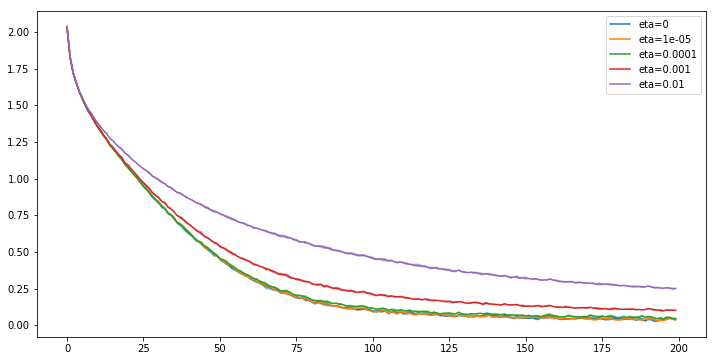

In [25]:
plt.figure(figsize=(12, 6))

for mode in modes:
    plt.plot(train_losses[mode].mean(axis=0))
    plt.fill_between(
        range(num_epochs),
        train_losses[mode].mean(axis=0) - train_losses[mode].std(axis=0),
        train_losses[mode].mean(axis=0) + train_losses[mode].std(axis=0),
        alpha=0.5
    )
plt.legend(modes)

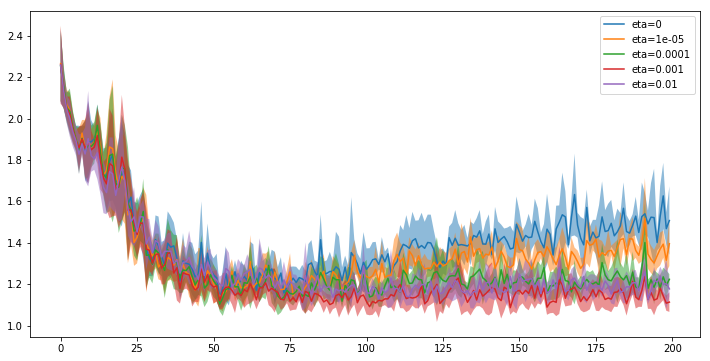

In [27]:
plt.figure(figsize=(12, 6))

for mode in modes:
    plt.plot(test_losses[mode].mean(axis=0))
    plt.fill_between(
        range(num_epochs),
        test_losses[mode].mean(axis=0) - test_losses[mode].std(axis=0),
        test_losses[mode].mean(axis=0) + test_losses[mode].std(axis=0),
        alpha=0.5
    )
plt.legend(modes)

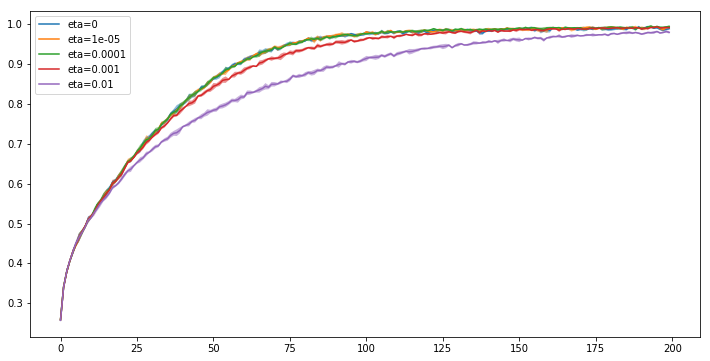

In [28]:
plt.figure(figsize=(12, 6))

for mode in modes:
    plt.plot(train_accs[mode].mean(axis=0))
    plt.fill_between(
        range(num_epochs),
        train_accs[mode].mean(axis=0) - train_accs[mode].std(axis=0),
        train_accs[mode].mean(axis=0) + train_accs[mode].std(axis=0),
        alpha=0.5
    )
plt.legend(modes)

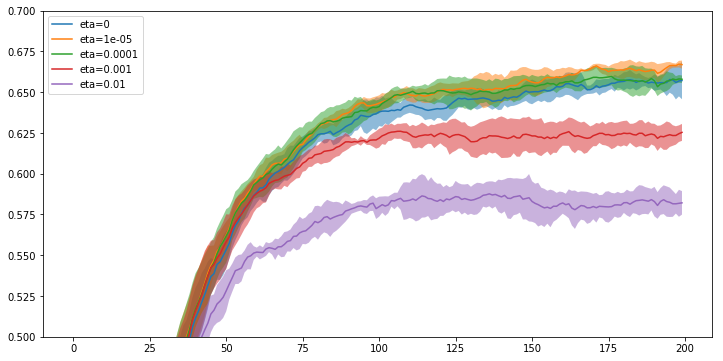

In [40]:
plt.figure(figsize=(12, 6))

alpha = 0.1
for mode in modes:
    curve = DataFrame(test_accs[mode]).ewm(alpha=alpha, axis=1).mean()
    plt.plot(curve.mean(axis=0))
    plt.fill_between(
        range(num_epochs),
        curve.mean(axis=0) - curve.std(axis=0),
        curve.mean(axis=0) + curve.std(axis=0),
        alpha=0.5
    )
plt.ylim(0.5, 0.7)
plt.legend(modes)

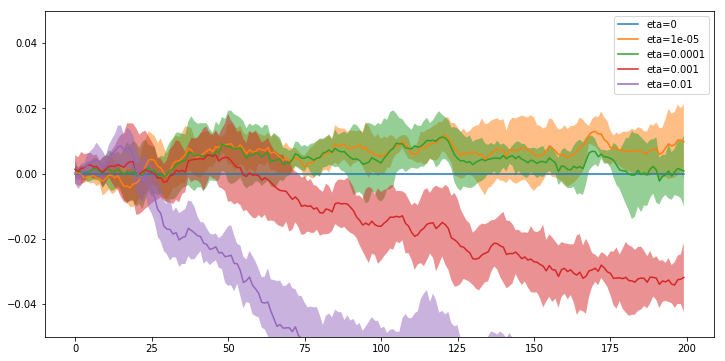

In [41]:
plt.figure(figsize=(12, 6))

for mode in modes:
    curve = DataFrame(test_accs[mode] - test_accs[modes[0]]).ewm(alpha=alpha, axis=1).mean()
    plt.plot(curve.mean(axis=0))
    plt.fill_between(
        range(num_epochs),
        curve.mean(axis=0) - curve.std(axis=0),
        curve.mean(axis=0) + curve.std(axis=0),
        alpha=0.5
    )
plt.ylim(-0.05, 0.05)
plt.legend(modes)

In [43]:
for mode in modes:
    print('{}: {:.2f} +- {:.2f}'.format(
        mode, 
        DataFrame(test_accs[mode]).ewm(alpha=alpha, axis=1).mean().mean(axis=0).max() * 100, 
        DataFrame(test_accs[mode]).ewm(alpha=alpha, axis=1).mean().std(axis=0)[
            np.argmax(DataFrame(test_accs[mode]).ewm(alpha=alpha, axis=1).mean().mean(axis=0))
        ] * 100, 
    ))

eta=0: 65.78 +- 0.81
eta=1e-05: 66.72 +- 0.20
eta=0.0001: 65.96 +- 0.54
eta=0.001: 62.60 +- 0.46
eta=0.01: 58.77 +- 0.76
